<div style="background-color: #f8d7da; color: #721c24; padding: 10px; border-radius: 5px; border: 1px solid #f5c6cb;">
    <strong>!Warning!</strong> Questo è un avviso importante, eseguire la cella sottostante prima di eseguire le altre celle del notebook.
</div>

In [58]:
# Eseguire prima delle altre celle

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
import torch
from torch import nn
import copy
import tqdm
from torch import optim
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import utils
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, BaggingClassifier)
from sklearn import tree
from sklearn.base import clone
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score, f1_score

# Introduzione  

Negli ultimi decenni, il web ha rivoluzionato il modo in cui la musica viene condivisa e fruita. Se un tempo le collezioni musicali erano limitate a una manciata di vinili o CD, oggi gli utenti hanno accesso immediato a vastissimi cataloghi musicali attraverso piattaforme online. Questa crescita esponenziale ha posto nuove sfide, tra cui:  

1. **L'organizzazione automatica delle collezioni musicali**, poiché la gestione manuale non è più sostenibile.  
2. **La raccomandazione automatica di nuove canzoni**, basata sulle preferenze di ascolto dell'utente.  

Un aspetto fondamentale per affrontare queste sfide è la capacità di raggruppare i brani in categorie semantiche, come i **generi musicali**. I generi musicali emergono dall’interazione di fattori culturali, artistici e di mercato e vengono utilizzati per descrivere somiglianze tra brani e organizzare le raccolte musicali. Tuttavia, i confini tra generi non sono sempre ben definiti, rendendo il compito del **riconoscimento automatico del genere musicale (Music Genre Recognition, MGR)** una sfida complessa.  

Nonostante le critiche legate alla soggettività e alla variabilità culturale dei generi musicali, essi rimangono una categorizzazione intuitiva e ampiamente utilizzata dagli utenti per descrivere e scoprire nuova musica. Per questo motivo, il MGR è un tema di grande interesse nella ricerca nel campo del **Music Information Retrieval (MIR)**.  

Il compito affrontato in questo notebook è il **riconoscimento automatico del genere musicale** di un brano a partire esclusivamente dalla sua registrazione audio. Il dataset utilizzato per questo studio è il **FMA (Free Music Archive) dataset**, una raccolta di brani musicali curati e di alta qualità, disponibile pubblicamente per la ricerca. Questo compito è stato anche oggetto di una delle sfide ufficiali della **Web Conference (WWW2018)**.  

L'obiettivo di questo lavoro è esplorare tecniche di **apprendimento automatico** e **elaborazione del segnale audio** per classificare i brani nei rispettivi generi, analizzando le caratteristiche musicali e valutando l'efficacia di diversi modelli predittivi.  


# Dati e dataset

Il dataset **FMA (Free Music Archive)** fornisce un insieme di **feature pre-compute** estratte con la libreria **Librosa**, che descrivono diversi aspetti delle tracce audio e vengono utilizzate per la classificazione automatica del genere musicale.

Abbiamo utilizzato la **versione medium** del dataset, che contiene **25.000 tracce** della durata di **30 secondi**, appartenenti a **16 generi musicali**. Per la classificazione, **non abbiamo estratto nuove feature**, ma abbiamo sfruttato direttamente le feature già disponibili nel dataset.

### **Feature contenute nel dataset**

Le feature fornite rappresentano caratteristiche **timbriche, tonali e spettro-temporali** del segnale audio. Sono state calcolate su finestre di **2048 campioni**, con un **hop size di 512 campioni**, e per ciascuna di esse sono state estratte sette statistiche principali: **media, deviazione standard, asimmetria (skewness), curtosi, mediana, minimo e massimo**.

Di seguito le principali feature disponibili:

- **MFCC (Mel-Frequency Cepstral Coefficients) [140 dimensioni]**: rappresentano il timbro del suono e sono molto utilizzati nell'elaborazione audio.
- **Chroma Features [84 dimensioni]**: descrivono la distribuzione delle frequenze nella scala musicale, utili per analizzare tonalità e armonie.
- **Tonnetz Features [42 dimensioni]**: catturano la struttura armonica del brano e le relazioni tonali.
- **Spectral Centroid [7 dimensioni]**: indica il "centro di massa" dello spettro di frequenza, utile per distinguere tra suoni acuti e gravi.
- **Spectral Bandwidth [7 dimensioni]**: misura la dispersione delle frequenze attorno al centroide.
- **Spectral Contrast [49 dimensioni]**: quantifica la differenza tra le parti più intense e meno intense dello spettro.
- **Spectral Rolloff [7 dimensioni]**: identifica la frequenza sotto la quale si trova il **95% dell'energia spettrale**.
- **RMS Energy (Root Mean Square Energy) [7 dimensioni]**: misura l'energia complessiva del segnale, utile per analizzare il volume medio del brano.
- **Zero-Crossing Rate [7 dimensioni]**: conta il numero di volte in cui il segnale attraversa lo zero, utile per distinguere suoni percussivi da quelli armonici.

Queste informazioni sono memorizzate nel file **features.csv**, dove ogni riga rappresenta una traccia e ogni colonna una delle feature estratte.

### **Motivazione delle scelte**

Per ottenere una rappresentazione più efficace dei dati, avremmo potuto utilizzare degli **autoencoder**, una classe di reti neurali progettate per apprendere una rappresentazione compressa e significativa degli input. Gli autoencoder avrebbero potuto estrarre caratteristiche più astratte e strutturate dai dati audio, migliorando potenzialmente la classificazione dei generi musicali.

Tuttavia, il **formato audio** è complesso da gestire e richiede tecniche avanzate di elaborazione del segnale, come la conversione in spettrogrammi o l'uso di architetture specializzate per sequenze temporali, come le **RNN (Reti Neurali Ricorrenti)** o i **Transformer**. Poiché a lezione non abbiamo affrontato modelli per la gestione di **sequenze di dati**, abbiamo preferito evitare questa strada e concentrarci sull'utilizzo delle feature pre-estratte, già fornite nel dataset.

L'obiettivo del nostro lavoro è stato quindi analizzare e confrontare diverse tecniche di **machine learning**, valutando le performance ottenute con le feature disponibili.


# Analisi esplorativa

Innanzi tutto osserviamo che il nostro dataset conta un totale di 25000 osservazioni e 518 feature. Ad ognuna di esse è associato un genere target.

In [59]:
X = utils.load('./fma_metadata/features_medium.csv')
y = pd.read_csv('./fma_metadata/train_labels.csv', index_col=0)

np.testing.assert_array_equal(X.index, y.index)

X.shape, y.shape

((25000, 518), (25000, 1))

Verifichiamo ora quante occorrenze sono presenti nel nostro dataset

In [60]:
CATEGORIES = sorted(y["genre"].unique())

y.groupby('genre').size()

genre
blues                    74
classical               619
country                 178
easy listening           21
electronic             6314
experimental           2251
folk                   1519
hip-hop                2201
instrumental           1350
international          1018
jazz                    384
old-time / historic     510
pop                    1186
rock                   7103
soul-rnb                154
spoken                  118
dtype: int64

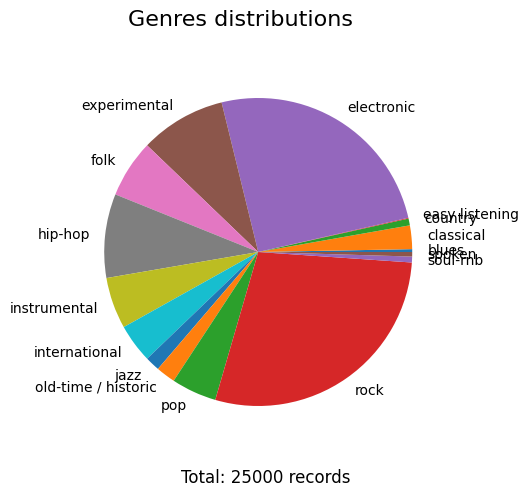

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5), facecolor='white')
fig.suptitle('Genres distributions', fontsize=16)

# plot a bar chart of genres
ax.pie(y.groupby('genre').size(), labels=CATEGORIES)
ax.text(-.5, -1.5, 'Total: {} records'.format(len(y)), fontsize=12)

plt.show()

Si evince quindi che il dataset è molto sbilanciato, con classi che contano migliaia di osservazioni e classi che ne contano poche decine. Segue poi un pò di datacleaning per assicurarci che tutti i dati siano nel giusto formato e non siano presenti valori strani 

In [62]:
%%capture

# Data cleaning
X = X.drop(utils.FILES_TRAIN_FAULTY)
y = y.drop(utils.FILES_TRAIN_FAULTY)

# The track IDs are integers for the training set.
X.index = pd.Index((int(i) for i in X.index), name='track_id')

# Should be done already, but better be sure.
X.sort_index(inplace=True)
y.sort_index(inplace=True)

# Data normalization
scaler = skl.preprocessing.StandardScaler(copy=False)
scaler.fit_transform(X)

Abbiamo poi eseguito un'analisi della **correlazione** tra le diverse feature del dataset per identificare eventuali relazioni lineari tra di esse. Questo ci ha permesso di capire meglio la struttura del dataset e di individuare feature ridondanti che potrebbero influire sulla performance dei modelli di machine learning.

Osserva che questa analisi è isolata alle sole "medie" delle varie feature.

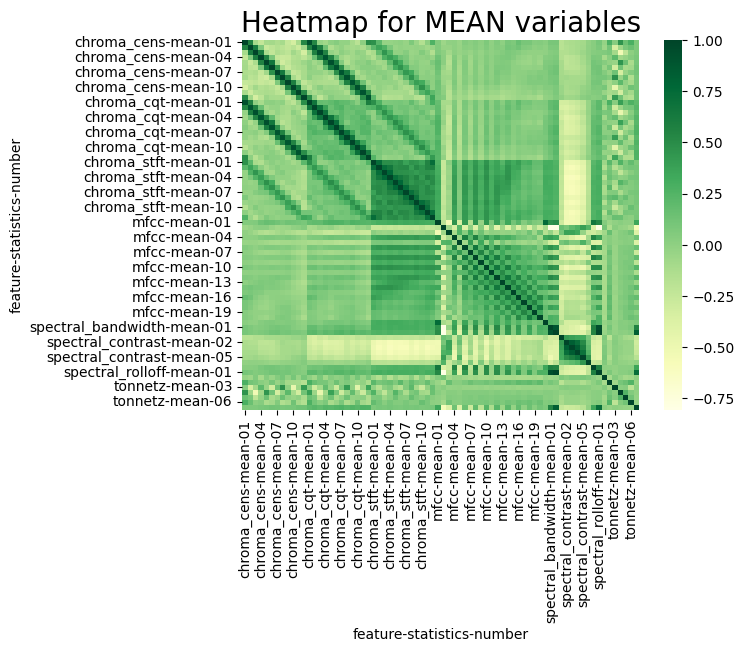

In [63]:
spike_cols = [col for col in X.columns if 'mean' in col] 
sns.heatmap(X[spike_cols].corr(), cmap='YlGn') 

plt.title('Heatmap for MEAN variables', fontsize = 20) 
plt.xticks(fontsize = 10) 
plt.yticks(fontsize = 10);

Nel'heatmap si possono notare dei blocchi di colore omogeneo. Quelli centrati sulla diagonale mettono in evidenza un'osservazione che ci saremmo potuti immaginare anche senza mappa: le stesse misurazioni fatte con parametri diversi (per esempio chroma_stft_10, chroma_stft_07...) sono altamente correlate tra di loro. Osserviamo però che blocchi omogenei sono presenti anche lontani dalla diagonale, questi mettono in evidenza della correlazione anche tra metriche diverse! Queste correlazioni possono essere sfruttate per ridurre la dimensionalità.

## Selezione delle feature più rilevanti

Successivamente, abbiamo applicato la **PCA (Principal Component Analysis)** per ridurre la dimensionalità del dataset. Questa tecnica ci ha permesso di comprimere le informazioni contenute nelle feature originali in un numero inferiore di componenti principali, preservando la maggior parte della varianza nei dati. La riduzione della dimensionalità è stata utile per semplificare il modello, migliorare l'efficienza computazionale e, in alcuni casi, ridurre il rischio di overfitting.

Il grafico sotto mostra che il 90% varianza del dataset è catturata da meno di 150 componenti.

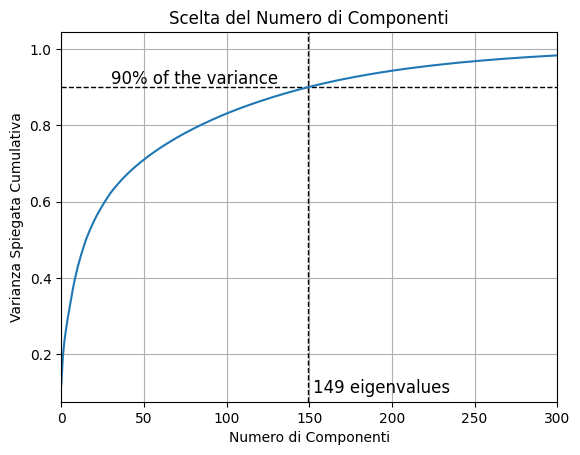

In [64]:
pca = PCA().fit(X)  # PCA senza specificare componenti

cumsum = np.cumsum(pca.explained_variance_ratio_)
idx = np.argmin(np.abs(cumsum - cumsum[-1]*.90))

# plot the eigenvalues horizontal line that represents the 95% of the variance
plt.axhline(cumsum[idx], color='black', linestyle='--', linewidth=1)
plt.text(30, cumsum[idx]+0.01, '90% of the variance', fontsize=12)

# plot the eigenvalues vertical line that represents the number of eigenvalues that represents the 95% of the variance
plt.axvline(idx, color='black', linestyle='--', linewidth=1)
plt.text(idx+3, 0.1, f'{idx} eigenvalues', fontsize=12)

plt.xlim(0, 300)
plt.plot(cumsum)
plt.xlabel("Numero di Componenti")
plt.ylabel("Varianza Spiegata Cumulativa")
plt.title("Scelta del Numero di Componenti")
plt.grid()
plt.show()

Estraiamo queste componenti e proiettiamo il dataset nel sottospazio generato dai loro autovettori. Allora la dimensionalità del dataset viene ridotta notevolmente.

Allora durante l'analisi dei modelli verrà considerato il dataset in tre forme:

- forma originale;
- proiettato nel sottospazio generato dagli autovettori associati ai primi 63 autovalori (75% della varianza del dataset);
- proiettato nel sottospazio generato dagli autovettori associati ai primi 149 autovalori (90% della varianza del dataset);

In [118]:
def split_dataset(X: pd.DataFrame, y: pd.DataFrame, test_size: float = 0.3, random_state: int = 42) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    train, test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return train, test, y_train, y_test


In [119]:
X_train, X_test, y_train, y_test = split_dataset(X,y,test_size=0.2,random_state=42)

# Be sure training samples are shuffled.
X_train, y_train = skl.utils.shuffle(X_train, y_train, random_state=42)

print("Forma originale:", X_train.shape)
percent = [.90, .75]

X_trains = []
X_tests = []

X_trains.append(X_train)
X_tests.append(X_test)

for p in percent:
    d = np.argmin(np.abs(cumsum - cumsum[-1]*p))
    pca_temp = PCA(n_components=d)
    X_trains.append(pd.DataFrame(pca_temp.fit_transform(X_train)))
    X_tests.append(pd.DataFrame(pca_temp.fit_transform(X_test)))

for x in X_trains[1:]:
    print("Dopo PCA", x.shape)

Forma originale: (19983, 518)
Dopo PCA (19983, 149)
Dopo PCA (19983, 63)


In [67]:

# print("Forma originale:", X_train.shape)
# d = 80
# pca = PCA(n_components=d)  # Riduzione a 20 componenti
# pca.fit(X)
# X_train = pca.transform(X_train)
# X_test = pca.transform(X_test)
# # data pre-processing

# print("Dopo PCA:", X_train.shape)

Vediamo ora quali sono le feature che abbiamo selezionato e "quanta" varianza spiegano

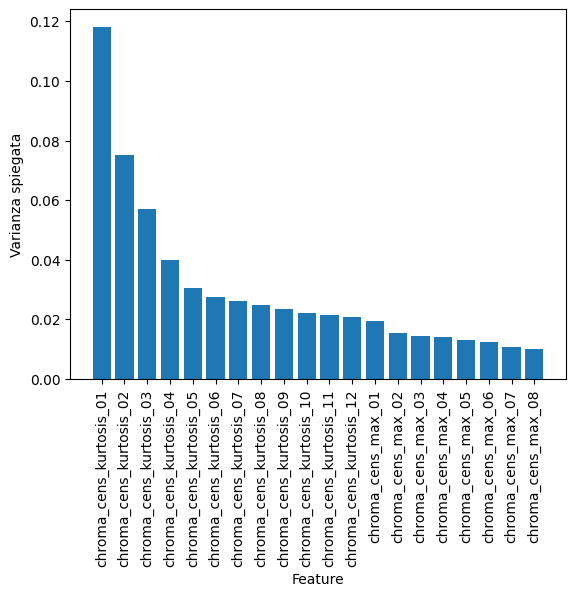

In [68]:
col_names = [name+"_"+stat+"_"+parameter for (name, stat, parameter) in X.columns]

important_features = np.abs(pca.components_[0])  # Prendi il valore assoluto della prima componente
feature_importance = list(zip(col_names, pca.explained_variance_ratio_))
feature_importance.sort(key=lambda x: x[1], reverse=True)  # Ordina per importanza
pca_feature_importance = feature_importance[:20]
pca_feature_importance_keys = [feature for (feature, value) in pca_feature_importance]
pca_feature_importance_value = [value for (feature, value) in pca_feature_importance]

fig, ax = plt.subplots()

# Creazione del bar chart
ax.bar(pca_feature_importance_keys ,pca_feature_importance_value)

# Aggiungere etichette e titolo
ax.set_xlabel('Feature')
ax.set_ylabel('Varianza spiegata')
plt.xticks(rotation=90)

# Mostrare il grafico
plt.show()

# Modelli
Per affrontare il compito di classificazione del genere musicale sul dataset **FMA (Free Music Archive)**, sono stati testati diversi modelli di machine learning al fine di confrontarne le performance e identificare l'approccio più efficace. Ogni modello scelto rappresenta una tecnica classica o avanzata di classificazione, in grado di gestire il tipo di dati e le feature pre-estratte dal dataset.

I modelli implementati comprendono:

- **Support Vector Machine (SVM)**
- **Decision Tree**
- **Bagging**
- **Boosting**
- **Rete Neurale**
- **Softmax Regression**
- **Gaussian Discriminant Analysis (GDA)**
- **k-Nearest Neighbors (kNN)**

Questi modelli sono stati scelti per sfruttare diversi approcci al machine learning, esplorando tanto metodi parametrici quanto non-parametrici, e approcci basati su ensemble per massimizzare la performance nel task di classificazione automatica del genere musicale.

Per ogni modello che sperimentiamo riportiamo la matrice di confusione e le metriche più importanti (Guarda cella sotto).

Le definizione delle metriche che abbiamo analizzato sono riportate qui:

### Metriche di valutazione

$$
\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
$$

$$
\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
$$

$$
\text{F1-score}_i = 2 \cdot \frac{\text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
$$

### Medie delle metriche

$$
\text{Macro Precision} = \frac{1}{N} \sum_{i=1}^{N} \text{Precision}_i
$$

$$
\text{Macro Recall} = \frac{1}{N} \sum_{i=1}^{N} \text{Recall}_i
$$

$$
\text{Macro F1-score} = \frac{1}{N} \sum_{i=1}^{N} \text{F1-score}_i
$$

**Weighted Average**  
(calcolata pesando ogni classe in base alla sua frequenza):

$$
\text{Weighted Precision} = \sum_{i=1}^{N} w_i \cdot \text{Precision}_i
$$

$$
\text{Weighted Recall} = \sum_{i=1}^{N} w_i \cdot \text{Recall}_i
$$

$$
\text{Weighted F1-score} = \sum_{i=1}^{N} w_i \cdot \text{F1-score}_i
$$

Dove:
- \( TP_i \) = True Positives per la classe \( i \)
- \( FP_i \) = False Positives per la classe \( i \)
- \( FN_i \) = False Negatives per la classe \( i \)
- \( N \) è il numero di classi
- \( w_i \) è il peso della classe \( i \), definito come la proporzione di campioni appartenenti a quella classe rispetto al totale.





In [69]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel='True label',
        xlabel='Predicted label'
    )
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha='right',
        rotation_mode='anchor'
    )
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center', color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

def valuate(clf, x_test, y_test, title = 'Confusion matrix'):
    y_pred = clf.predict(x_test)
    plot_confusion_matrix(y_test, y_pred, classes=clf.classes_, title=title)    
    print(classification_report(y_test, y_pred))


# Support Vector Machine for classification

Il primo modello che abbiamo utilizzato è la Support Vector Machine appositamente adattata per i task di classificazione. Nello specifico, abbiamo usato la funzine kernel *Radial Basis Function* (RBF), visto che ha la caratteristica peculiare di far aumentare la distanza dagli altri punti in modo esponenziale.

                     precision    recall  f1-score   support

              Blues       0.00      0.00      0.00         9
          Classical       0.82      0.89      0.85        70
            Country       0.00      0.00      0.00        16
     Easy Listening       0.00      0.00      0.00         1
         Electronic       0.62      0.81      0.70       600
       Experimental       0.48      0.41      0.45       216
               Folk       0.60      0.61      0.60       146
            Hip-Hop       0.70      0.59      0.64       211
       Instrumental       0.59      0.40      0.48       145
      International       0.74      0.41      0.53       116
               Jazz       0.54      0.19      0.28        37
Old-Time / Historic       0.98      0.98      0.98        41
                Pop       0.38      0.05      0.08       131
               Rock       0.72      0.88      0.79       728
           Soul-RnB       0.00      0.00      0.00        20
             Spoken    

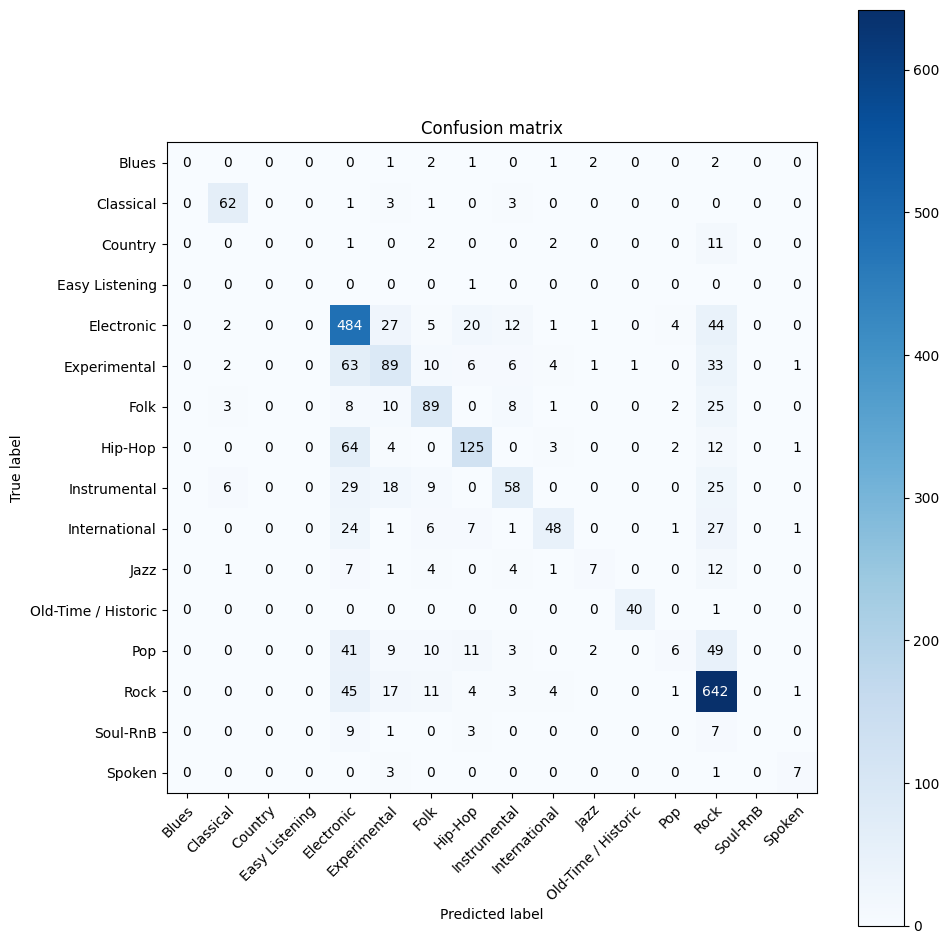

In [10]:
# svm_clf = sklearn.svm.SVC(kernel="rbf")
# svm_clf.fit(X_train, y_train)
# valuate(svm_clf, X_test, y_test)

In [72]:
def svm(X_train, y_train, X_test, y_test, title: str = 'SVM'):

    # create the model
    model = sklearn.svm.SVC(kernel="rbf",gamma='scale')

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.79      0.84      0.82       129
            country       1.00      0.07      0.12        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.66      0.84      0.74      1264
       experimental       0.48      0.50      0.49       447
               folk       0.68      0.67      0.67       318
            hip-hop       0.71      0.57      0.63       438
       instrumental       0.57      0.43      0.49       284
      international       0.72      0.46      0.56       199
               jazz       0.72      0.33      0.45        88
old-time / historic       0.97      0.97      0.97        96
                pop       0.43      0.07      0.12       222
               rock       0.75      0.87      0.80      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

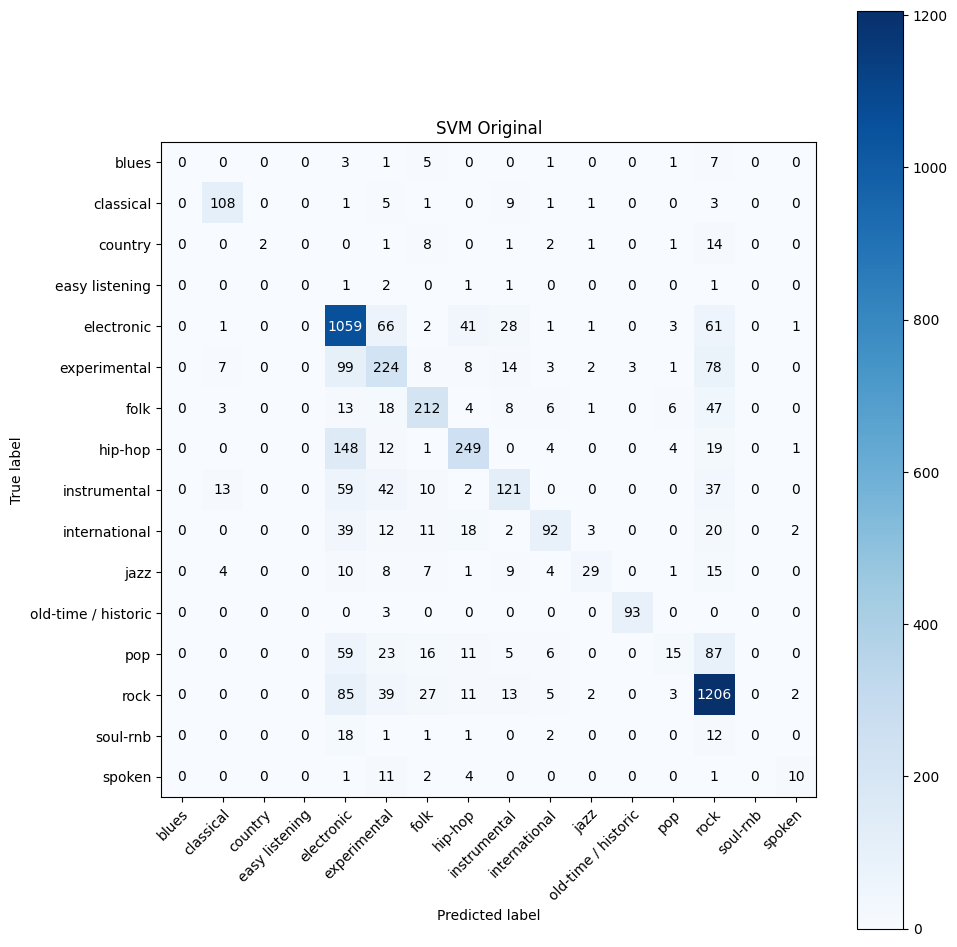

In [73]:
svm(X_trains[0], y_train, X_tests[0], y_test, title="SVM Original")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.78      0.84      0.81       129
            country       1.00      0.03      0.06        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.65      0.83      0.73      1264
       experimental       0.49      0.47      0.48       447
               folk       0.66      0.64      0.65       318
            hip-hop       0.69      0.55      0.61       438
       instrumental       0.55      0.42      0.47       284
      international       0.71      0.45      0.55       199
               jazz       0.71      0.33      0.45        88
old-time / historic       0.96      0.97      0.96        96
                pop       0.36      0.04      0.07       222
               rock       0.73      0.86      0.79      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

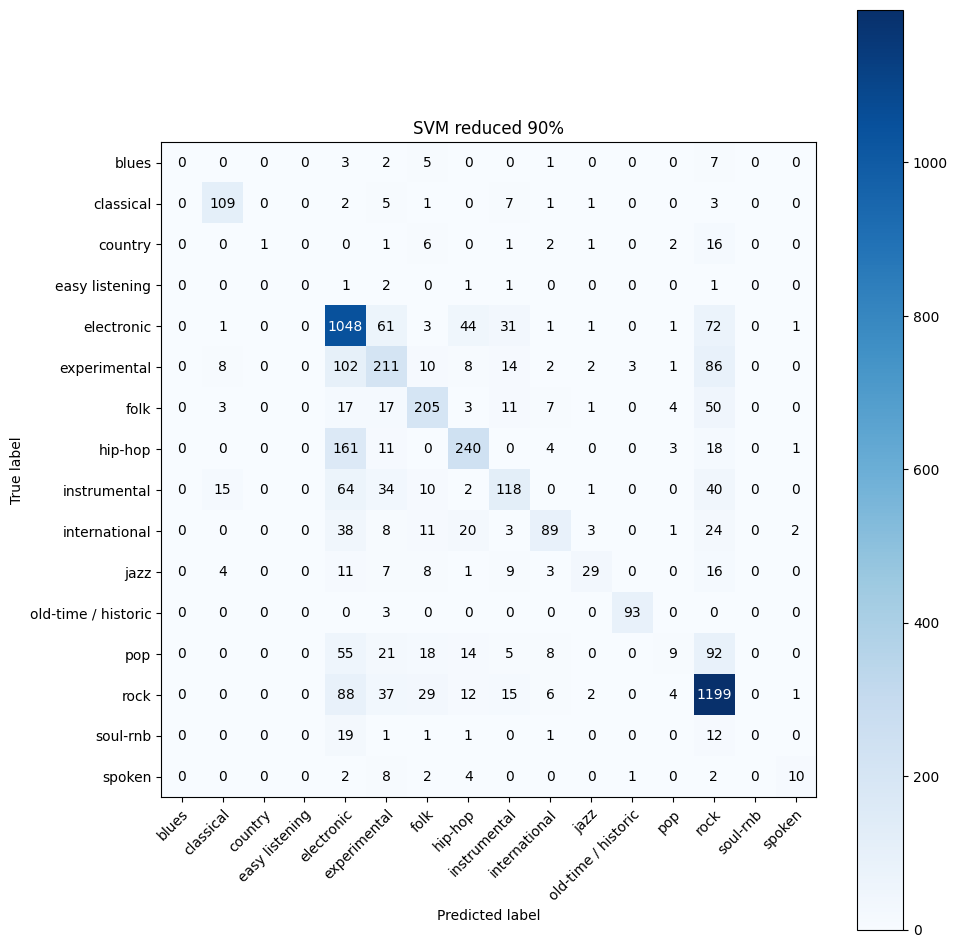

In [74]:
svm(X_trains[1], y_train, X_tests[1], y_test, title="SVM reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.75      0.80      0.77       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.64      0.82      0.72      1264
       experimental       0.48      0.43      0.46       447
               folk       0.63      0.64      0.64       318
            hip-hop       0.66      0.52      0.58       438
       instrumental       0.52      0.38      0.44       284
      international       0.64      0.41      0.50       199
               jazz       0.70      0.30      0.42        88
old-time / historic       0.95      0.98      0.96        96
                pop       0.38      0.03      0.05       222
               rock       0.72      0.86      0.79      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

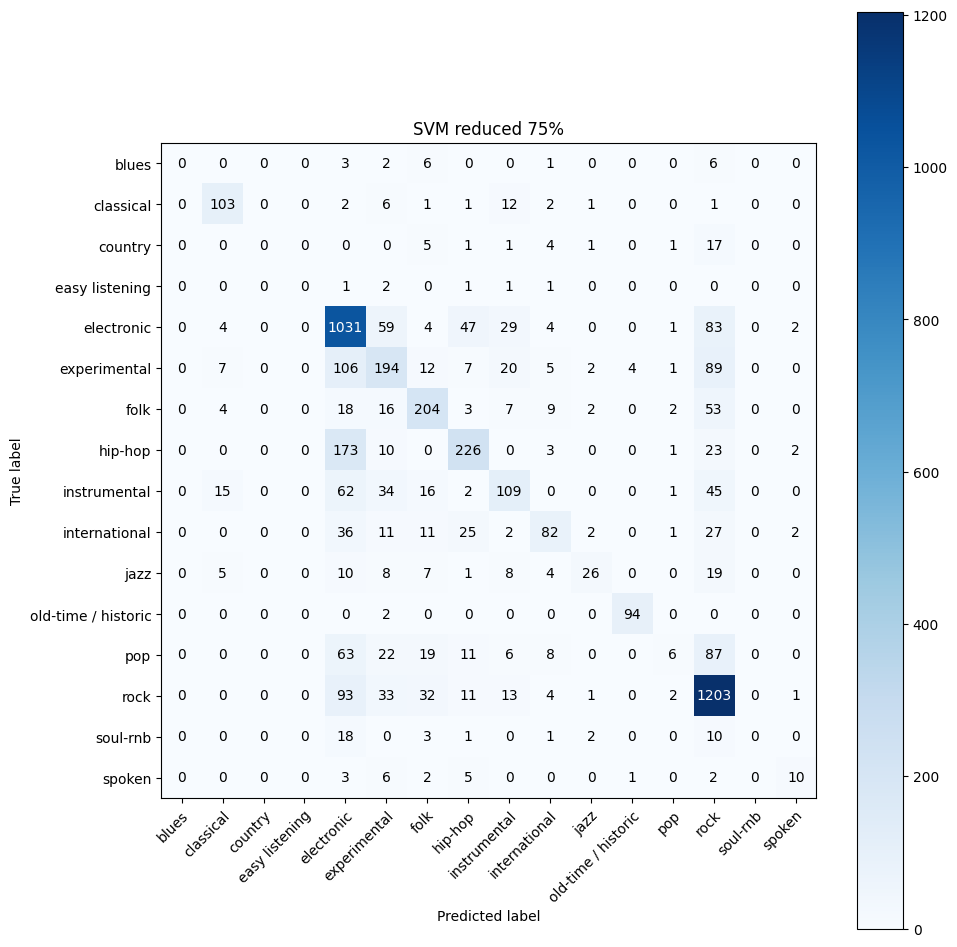

In [76]:
svm(X_trains[2], y_train, X_tests[2], y_test, title="SVM reduced 75%")

# Tree-based models

In questa sezione esploriamo i modelli basati su strutture ad albero:
- Decision Tree
- Bagging
- Random Forest
- AdaBoost

Per ogni modello proponiamo una specifica configurazione dei meta-parametri e poi esploriamo le sue performance al variare di questi.

## Decision Tree

In questo caso fissiamo *max_depth*=10.


In [77]:
maxdepth=10
def tree_clf(X_train, y_train, X_test, y_test, maxdepth = 10, title: str = 'Decision Tree'):

    # create the model
    model = tree.DecisionTreeClassifier(max_depth=maxdepth, class_weight='balanced')

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)


                     precision    recall  f1-score   support

              blues       0.02      0.11      0.03        18
          classical       0.46      0.66      0.54       129
            country       0.05      0.53      0.09        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.54      0.23      0.32      1264
       experimental       0.30      0.20      0.24       447
               folk       0.31      0.41      0.35       318
            hip-hop       0.28      0.32      0.30       438
       instrumental       0.28      0.29      0.29       284
      international       0.11      0.37      0.17       199
               jazz       0.12      0.28      0.17        88
old-time / historic       0.77      0.83      0.80        96
                pop       0.02      0.01      0.01       222
               rock       0.72      0.51      0.60      1393
           soul-rnb       0.03      0.17      0.06        35
             spoken    

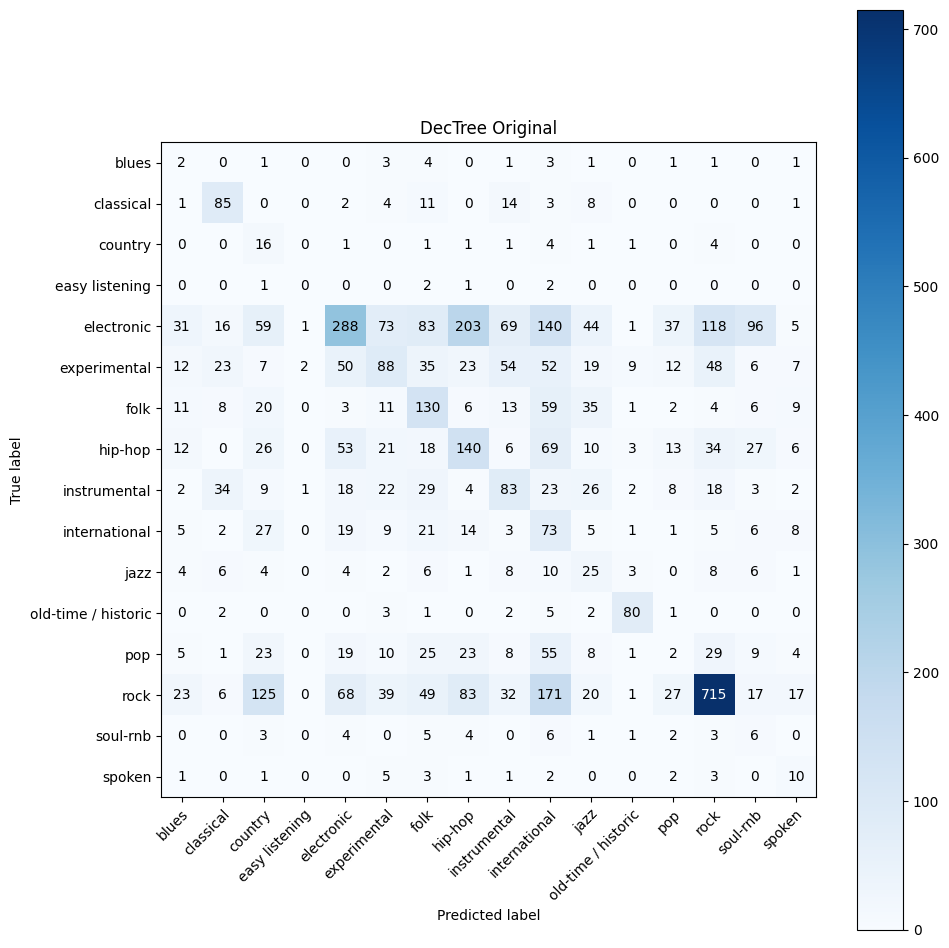

In [78]:
tree_clf(X_trains[0], y_train, X_tests[0], y_test, maxdepth=maxdepth, title="DecTree Original")

                     precision    recall  f1-score   support

              blues       0.01      0.17      0.02        18
          classical       0.35      0.52      0.42       129
            country       0.02      0.53      0.04        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.66      0.24      0.36      1264
       experimental       0.22      0.12      0.15       447
               folk       0.24      0.25      0.25       318
            hip-hop       0.29      0.50      0.37       438
       instrumental       0.23      0.20      0.21       284
      international       0.15      0.08      0.10       199
               jazz       0.09      0.14      0.11        88
old-time / historic       0.70      0.71      0.70        96
                pop       0.11      0.09      0.10       222
               rock       0.68      0.41      0.51      1393
           soul-rnb       0.06      0.23      0.10        35
             spoken    

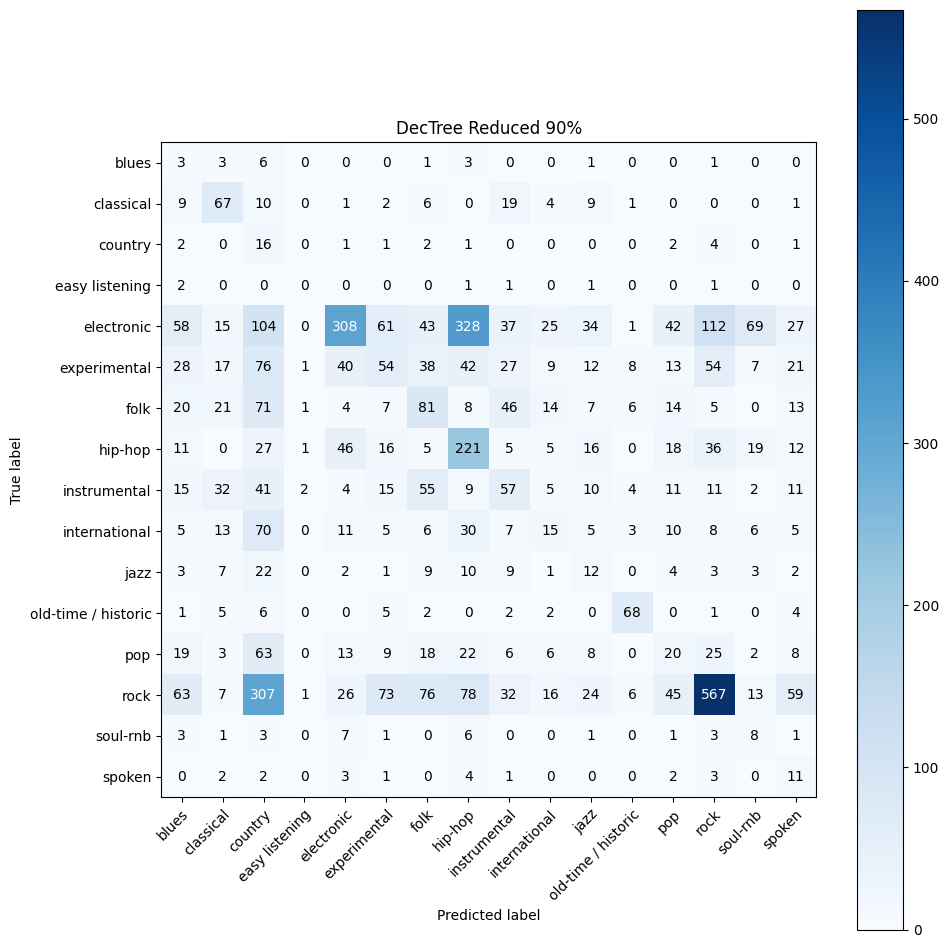

In [79]:
tree_clf(X_trains[1], y_train, X_tests[1], y_test, maxdepth=maxdepth, title="DecTree Reduced 90%")

                     precision    recall  f1-score   support

              blues       0.01      0.06      0.02        18
          classical       0.39      0.45      0.42       129
            country       0.01      0.40      0.03        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.64      0.26      0.37      1264
       experimental       0.22      0.13      0.17       447
               folk       0.28      0.35      0.31       318
            hip-hop       0.35      0.47      0.40       438
       instrumental       0.27      0.17      0.21       284
      international       0.12      0.18      0.15       199
               jazz       0.06      0.19      0.09        88
old-time / historic       0.70      0.73      0.71        96
                pop       0.09      0.10      0.09       222
               rock       0.66      0.37      0.48      1393
           soul-rnb       0.03      0.17      0.06        35
             spoken    

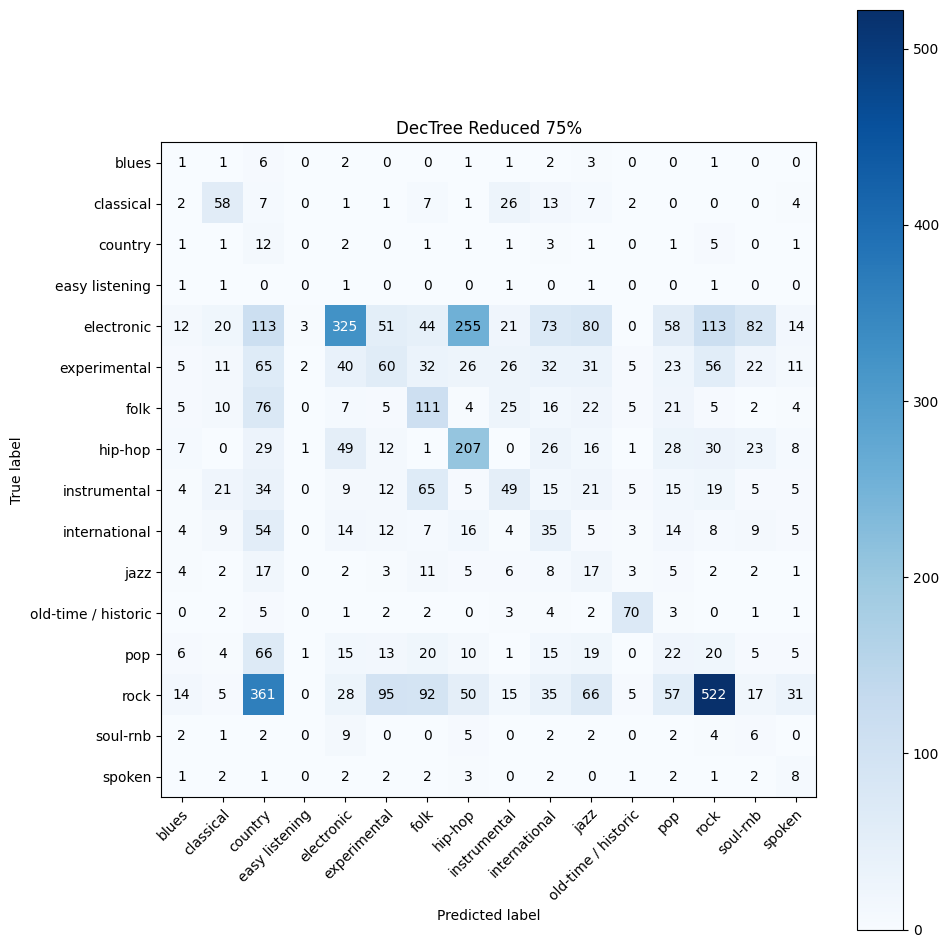

In [80]:
tree_clf(X_trains[2], y_train, X_tests[2], y_test, maxdepth=maxdepth, title="DecTree Reduced 75%")

Di seguito, invece, facciamo variare il parametri delle *max_depth* con i valori nella lista [5, 10, 15, 20, 25, 30]. Dal grafico in basso, si vede che le massime prestazioni si ottengono con un altezza pari a 25.

n_estimators=5: Accuracy=0.2246, F1_weighted=0.2350
n_estimators=10: Accuracy=0.3026, F1_weighted=0.3431
n_estimators=15: Accuracy=0.3437, F1_weighted=0.3773
n_estimators=20: Accuracy=0.3697, F1_weighted=0.3841
n_estimators=25: Accuracy=0.3667, F1_weighted=0.3721
n_estimators=30: Accuracy=0.3707, F1_weighted=0.3737


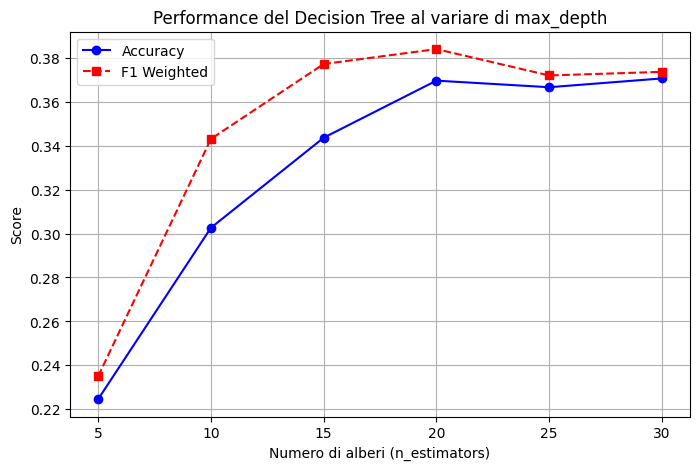

In [81]:
X_train, X_test = X_trains[1], X_tests[1]
n_estimators_values = [5, 10, 15, 20, 25, 30]

# Liste per raccogliere le metriche
accuracies = []
f1_scores = []

# Loop per testare diversi valori di n_estimators
for n in n_estimators_values:
    model = tree.DecisionTreeClassifier(max_depth=n, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracies.append(acc)
    f1_scores.append(f1)

    print(f"n_estimators={n}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Plotta le metriche
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_values, accuracies, marker='o', linestyle='-', label="Accuracy", color='b')
plt.plot(n_estimators_values, f1_scores, marker='s', linestyle='--', label="F1 Weighted", color='r')

plt.xlabel("Numero di alberi (n_estimators)")
plt.ylabel("Score")
plt.title("Performance del Decision Tree al variare di max_depth")
plt.legend()
plt.grid()
plt.show()

## Bagging

La configurazione dei parametri che proponiamo è la seguente:
- *max_depth* = 1
- *n_estimators* = 8 (Numero di aberi)

Così, otteniamo i risultati in basso

In [88]:
n_est = 8
md = 1

def bagging_clf(X_train, y_train, X_test, y_test, n_est = 8, md = 1, title: str = 'Bagging'):

    # create the model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    model = BaggingClassifier(classifier,n_estimators=n_est)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.00      0.00      0.00       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.33      0.87      0.48      1264
       experimental       0.00      0.00      0.00       447
               folk       0.00      0.00      0.00       318
            hip-hop       0.00      0.00      0.00       438
       instrumental       0.00      0.00      0.00       284
      international       0.00      0.00      0.00       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.00      0.00      0.00        96
                pop       0.00      0.00      0.00       222
               rock       0.55      0.67      0.60      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

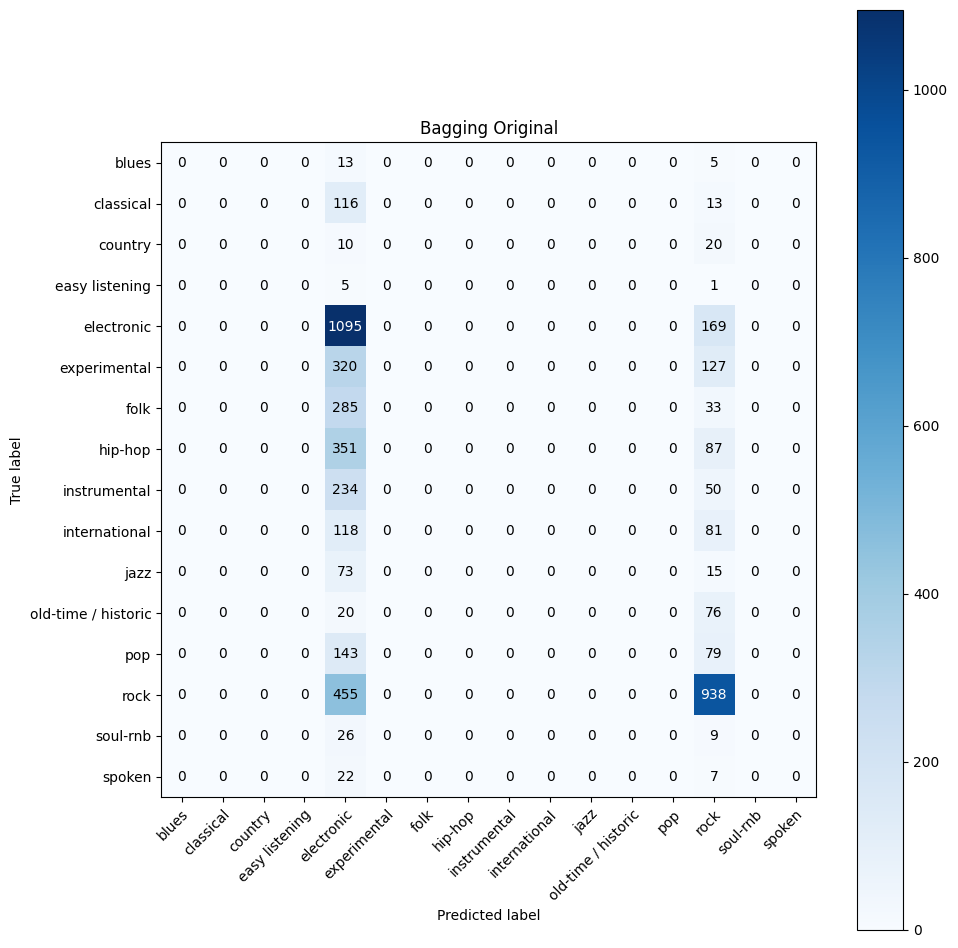

In [85]:
bagging_clf(X_trains[0], y_train, X_tests[0], y_test, n_est = n_est, md = md, title = 'Bagging Original')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.00      0.00      0.00       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.49      0.61      0.55      1264
       experimental       0.00      0.00      0.00       447
               folk       0.00      0.00      0.00       318
            hip-hop       0.00      0.00      0.00       438
       instrumental       0.00      0.00      0.00       284
      international       0.00      0.00      0.00       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.00      0.00      0.00        96
                pop       0.00      0.00      0.00       222
               rock       0.36      0.90      0.52      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

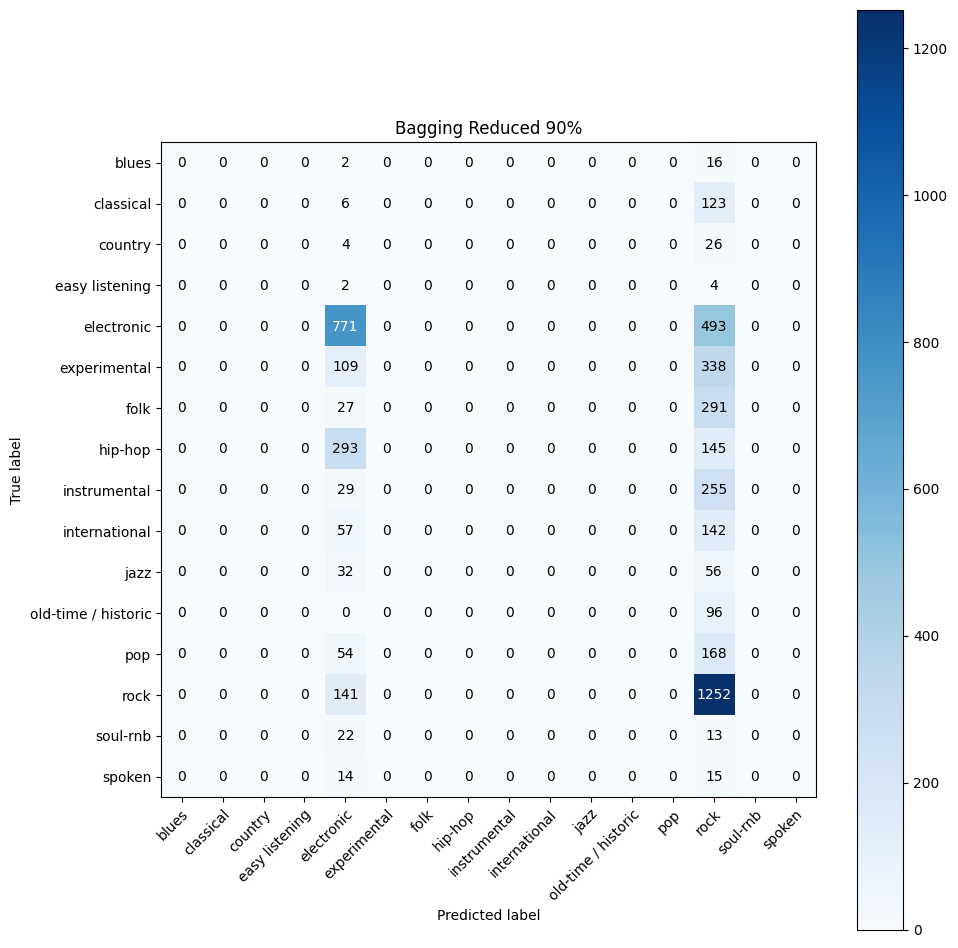

In [86]:
bagging_clf(X_trains[1], y_train, X_tests[1], y_test, n_est = n_est, md = md, title = 'Bagging Reduced 90%')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.00      0.00      0.00       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.48      0.64      0.55      1264
       experimental       0.00      0.00      0.00       447
               folk       0.00      0.00      0.00       318
            hip-hop       0.00      0.00      0.00       438
       instrumental       0.00      0.00      0.00       284
      international       0.00      0.00      0.00       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.00      0.00      0.00        96
                pop       0.00      0.00      0.00       222
               rock       0.37      0.88      0.52      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

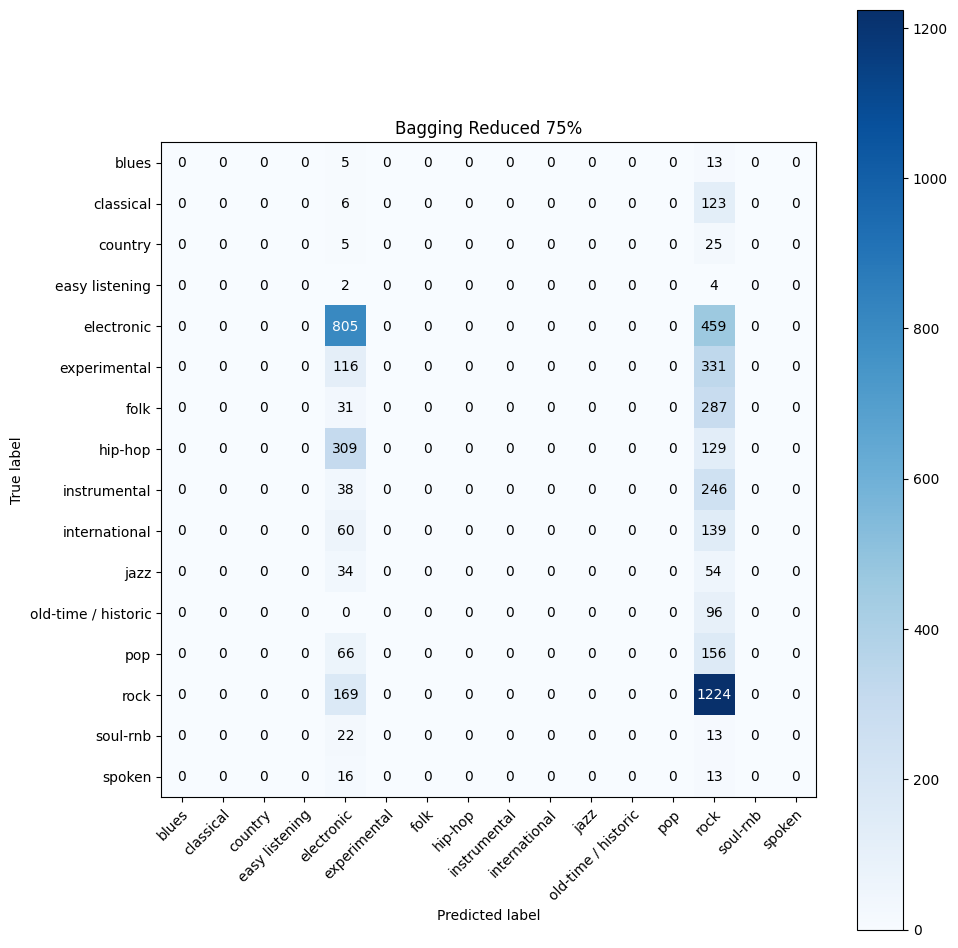

In [87]:
bagging_clf(X_trains[2], y_train, X_tests[2], y_test, n_est = n_est, md = md, title = 'Bagging Reduced 75%')

Esploriamo ora le performance del bagging facendo variare i meta-parametri, nello specifico:
- *max_depth* $\in$ [5, 10, 20, 30, 40] 
- *n_estimators* $\in$ [1,3, 5, 10, None]

n_trees=5, max_depth=1: Accuracy=0.4087, F1_weighted=0.2828
n_trees=5, max_depth=3: Accuracy=0.4331, F1_weighted=0.3426
n_trees=5, max_depth=5: Accuracy=0.4828, F1_weighted=0.4159
n_trees=5, max_depth=10: Accuracy=0.5276, F1_weighted=0.4813
n_trees=5, max_depth=None: Accuracy=0.4916, F1_weighted=0.4648
n_trees=10, max_depth=1: Accuracy=0.4039, F1_weighted=0.2791
n_trees=10, max_depth=3: Accuracy=0.4355, F1_weighted=0.3456
n_trees=10, max_depth=5: Accuracy=0.4824, F1_weighted=0.4053
n_trees=10, max_depth=10: Accuracy=0.5384, F1_weighted=0.4888
n_trees=10, max_depth=None: Accuracy=0.5264, F1_weighted=0.4910
n_trees=20, max_depth=1: Accuracy=0.4035, F1_weighted=0.2789
n_trees=20, max_depth=3: Accuracy=0.4363, F1_weighted=0.3479
n_trees=20, max_depth=5: Accuracy=0.4864, F1_weighted=0.4201
n_trees=20, max_depth=10: Accuracy=0.5480, F1_weighted=0.4940
n_trees=20, max_depth=None: Accuracy=0.5512, F1_weighted=0.5135
n_trees=30, max_depth=1: Accuracy=0.4035, F1_weighted=0.2789
n_trees=30, max_d

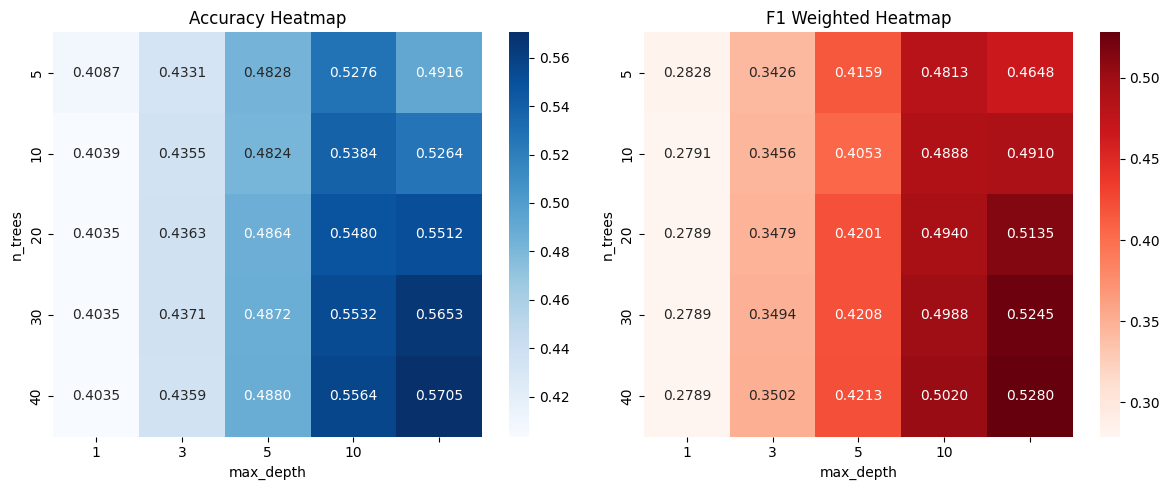

'\nn_estimators = 8\nmd = 1\nclassifier = tree.DecisionTreeClassifier(max_depth=md)\n\nbagging_clf = BaggingClassifier(classifier,n_estimators=n_estimators)\n\nbagging_clf = bagging_clf.fit(X_train, y_train)\nvaluate(bagging_clf, X_test, y_test)\n'

In [ ]:
X_train, X_test = X_trains[1], X_tests[1]
n_trees_values = [5, 10, 20, 30, 40]  # Numero di alberi nel bagging
max_depth_values = [1,3, 5, 10, None]  # Profondità degli alberi (None = senza limite)

# Matrici per salvare le metriche
accuracy_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))
f1_matrix = np.zeros((len(n_trees_values), len(max_depth_values)))

# Loop su entrambi i parametri
for i, n_trees in enumerate(n_trees_values):
    for j, depth in enumerate(max_depth_values):
        base_tree = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = BaggingClassifier(estimator=base_tree, n_estimators=n_trees, random_state=42)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        accuracy_matrix[i, j] = acc
        f1_matrix[i, j] = f1

        print(f"n_trees={n_trees}, max_depth={depth}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione delle heatmap per visualizzare i risultati
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(accuracy_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Blues", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_trees")

sns.heatmap(f1_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_trees_values, cmap="Reds", ax=ax[1])
ax[1].set_title("F1 Weighted Heatmap")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_trees")

plt.tight_layout()
plt.show()

## Random forest

Qui proponiamo una configurazione iniziale con 100 alberi di altezza al più 3. Seguono i risultati.

In [89]:
n_est = 100

def rnd_forest_clf(X_train, y_train, X_test, y_test, n_est = 100, title: str = 'Random forest'):

    # create the model
    model = RandomForestClassifier(n_estimators=n_est,max_depth=3)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

In [ ]:
rnd_forest_clf(X_trains[0], y_train, X_tests[0], y_test, n_est=n_est, title = "Random forest Original")

In [ ]:
rnd_forest_clf(X_trains[1], y_train, X_tests[1], y_test, n_est=n_est, title = "Random forest Reduced 90%")

In [ ]:
rnd_forest_clf(X_trains[2], y_train, X_tests[2], y_test, n_est=n_est, title = "Random forest Reduced 75%")

Come si può vedere dalla matrice sopra, le classi *Electronic* e *Rock* sono abbastanza patologiche, crediamo che questo comportamento sia dovuto all'eccessivo sbilanciamento del dataset. Ora esploriamo le performance del modello al variare di *n_trees_values* $\in$ [5, 10, 50, 100, 200, 500].

n_trees=5: Accuracy=0.4195, F1_weighted=0.2962
n_trees=10: Accuracy=0.4263, F1_weighted=0.3009
n_trees=50: Accuracy=0.4396, F1_weighted=0.3102
n_trees=100: Accuracy=0.4392, F1_weighted=0.3100
n_trees=200: Accuracy=0.4363, F1_weighted=0.3073
n_trees=500: Accuracy=0.4380, F1_weighted=0.3082


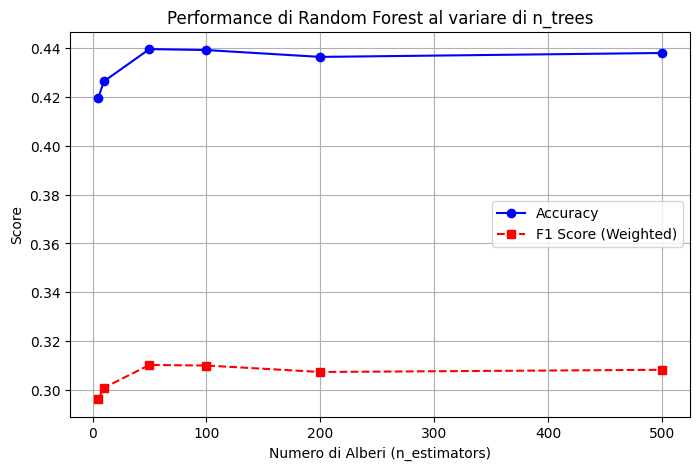

In [ ]:
X_train, X_test = X_trains[1], X_tests[1]
n_trees_values = [5, 10, 50, 100, 200, 500]

# Liste per salvare le metriche
accuracy_values = []
f1_values = []

# Loop su n_trees
for n_trees in n_trees_values:
    model = RandomForestClassifier(n_estimators=n_trees,max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_values.append(acc)
    f1_values.append(f1)

    print(f"n_trees={n_trees}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(n_trees_values, accuracy_values, marker='o', linestyle='-', label="Accuracy", color="blue")
plt.plot(n_trees_values, f1_values, marker='s', linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Numero di Alberi (n_estimators)")
plt.ylabel("Score")
plt.title("Performance di Random Forest al variare di n_trees")
plt.legend()
plt.grid(True)
plt.show()

## AdaBoost

In modo simile ai modelli precedenti, qui proponiamo una configurazione dei parametri con 8 alberi dalla altezza al più pari a 2.

In [96]:
n_est = 8
md = 2

def ada_clf(X_train, y_train, X_test, y_test, n_est = 8, md = 2, title: str = 'Random forest'):

    # create the model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    model = AdaBoostClassifier(classifier,n_estimators=n_est)

    # train the model
    model.fit(X_train, y_train)

    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

In [ ]:
ada_clf(X_trains[0], y_train, X_tests[0], y_test, n_est=n_est, md=md, title = "Adaboost Original")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.22      0.04      0.07       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.49      0.51      0.50      1264
       experimental       0.21      0.10      0.14       447
               folk       0.18      0.02      0.03       318
            hip-hop       0.32      0.28      0.30       438
       instrumental       0.19      0.45      0.27       284
      international       0.23      0.08      0.11       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.94      0.51      0.66        96
                pop       0.05      0.03      0.04       222
               rock       0.50      0.77      0.61      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

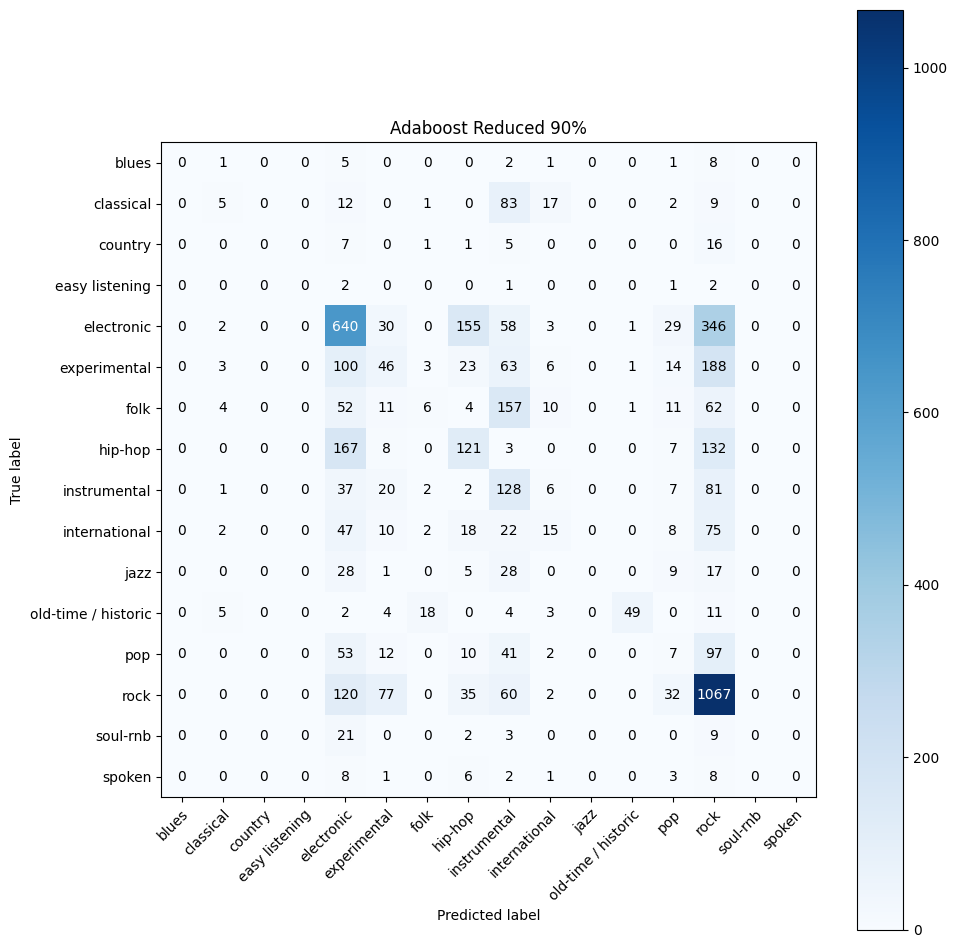

In [97]:
ada_clf(X_trains[1], y_train, X_tests[1], y_test, n_est=n_est, md=md, title = "Adaboost Reduced 90%")

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.22      0.04      0.07       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.49      0.51      0.50      1264
       experimental       0.21      0.10      0.14       447
               folk       0.18      0.02      0.03       318
            hip-hop       0.32      0.28      0.30       438
       instrumental       0.19      0.45      0.27       284
      international       0.23      0.08      0.11       199
               jazz       0.00      0.00      0.00        88
old-time / historic       0.94      0.51      0.66        96
                pop       0.05      0.03      0.04       222
               rock       0.50      0.77      0.61      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

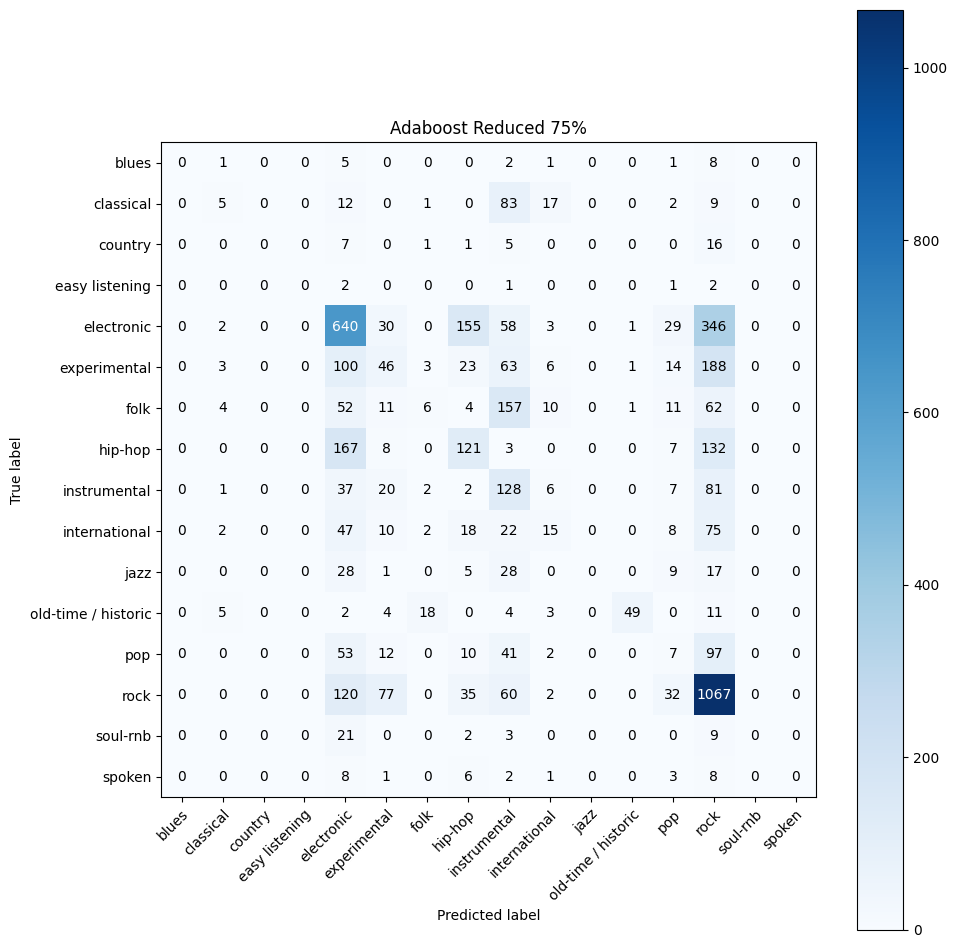

In [98]:
ada_clf(X_trains[2], y_train, X_tests[2], y_test, n_est=n_est, md=md, title = "Adaboost Reduced 75%")

Facciamo ora variare il numero di alberi in [10, 50, 100, 150, 200] e la *max_depth* in [1, 2, 3, 5, 10].

n_estimators=10, max_depth=1: Accuracy=0.3579, F1_weighted=0.2803
n_estimators=10, max_depth=2: Accuracy=0.4183, F1_weighted=0.3514
n_estimators=10, max_depth=3: Accuracy=0.4231, F1_weighted=0.3910
n_estimators=10, max_depth=5: Accuracy=0.4432, F1_weighted=0.4278
n_estimators=10, max_depth=10: Accuracy=0.4688, F1_weighted=0.4413
n_estimators=50, max_depth=1: Accuracy=0.3947, F1_weighted=0.3529
n_estimators=50, max_depth=2: Accuracy=0.4628, F1_weighted=0.4197
n_estimators=50, max_depth=3: Accuracy=0.4664, F1_weighted=0.4451
n_estimators=50, max_depth=5: Accuracy=0.4528, F1_weighted=0.4492
n_estimators=50, max_depth=10: Accuracy=0.5068, F1_weighted=0.4790
n_estimators=100, max_depth=1: Accuracy=0.4067, F1_weighted=0.3692
n_estimators=100, max_depth=2: Accuracy=0.4448, F1_weighted=0.4195
n_estimators=100, max_depth=3: Accuracy=0.4528, F1_weighted=0.4391
n_estimators=100, max_depth=5: Accuracy=0.4664, F1_weighted=0.4597
n_estimators=100, max_depth=10: Accuracy=0.5456, F1_weighted=0.5132
n_

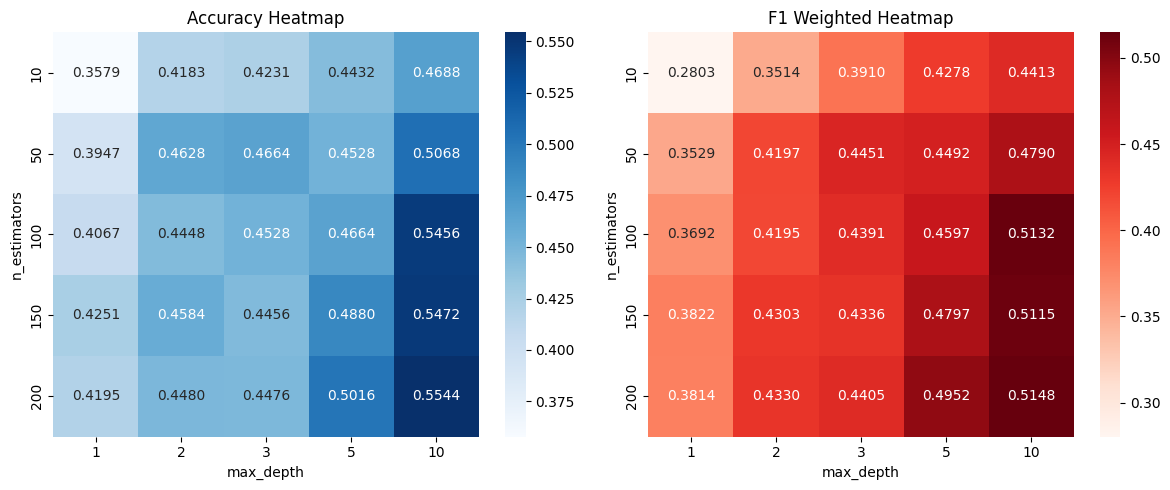

"scores_train = []\nscores_test = []\nmd = 2\nr = range(1,30)\nfor k in r:\n    ada_clf = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth=md),n_estimators=k, algorithm='SAMME')\n    ada_clf = ada_clf.fit(X_train, y_train)\n    score_train = ada_clf.score(X_train, y_train)\n    score_test = ada_clf.score(X_test, y_test)\n    scores_train.append(score_train)\n    scores_test.append(score_test)\n\nfig = plt.figure(figsize=(16,8))\nax = fig.gca()\nplt.plot(r, scores_train)\nplt.plot(r, scores_test) \nplt.xlabel(r'Numero di weak learner')\nplt.ylabel('Accuracy')\nplt.title(r'Accuracy al variare del numero di weak learner')\nplt.show()"

In [ ]:
X_train, X_test = X_trains[1], X_tests[1]
n_estimators_values = [10, 50, 100, 150, 200]  # Numero di stadi del boosting
max_depth_values = [1, 2, 3, 5, 10]  # Profondità degli alberi base

# Matrici per salvare le metriche
accuracy_matrix = np.zeros((len(n_estimators_values), len(max_depth_values)))
f1_matrix = np.zeros((len(n_estimators_values), len(max_depth_values)))

# Loop su entrambi i parametri
for i, n_estimators in enumerate(n_estimators_values):
    for j, depth in enumerate(max_depth_values):
        base_tree = tree.DecisionTreeClassifier(max_depth=depth, random_state=42)
        model = AdaBoostClassifier(estimator=base_tree, n_estimators=n_estimators, random_state=42)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        accuracy_matrix[i, j] = acc
        f1_matrix[i, j] = f1

        print(f"n_estimators={n_estimators}, max_depth={depth}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione delle heatmap per visualizzare i risultati
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(accuracy_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_estimators_values, cmap="Blues", ax=ax[0])
ax[0].set_title("Accuracy Heatmap")
ax[0].set_xlabel("max_depth")
ax[0].set_ylabel("n_estimators")

sns.heatmap(f1_matrix, annot=True, fmt=".4f", xticklabels=max_depth_values, yticklabels=n_estimators_values, cmap="Reds", ax=ax[1])
ax[1].set_title("F1 Weighted Heatmap")
ax[1].set_xlabel("max_depth")
ax[1].set_ylabel("n_estimators")

plt.tight_layout()
plt.show()

# Rete Neurale 

La rete neurale è un modello molto complesso che abbiamo soltanto introdotto durante il corso. Qui proponiamo un'architettura a tre layer, con solo uno hidden, il quale è munito di funzione di attivazione ReLu.

In [103]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoding(y):
    y = y.values.reshape(-1, 1)
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)
    y = ohe.transform(y)
    return y

In [104]:
# Feedforward neural network
X_train, X_test = X_trains[1], X_tests[1]
d = 149

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

class MultiClassNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(d, d)
        self.act = nn.ReLU()
        self.output = nn.Linear(d, 16)

    def forward(self, x):
        x = self.act(self.hidden(x))
        x = self.output(x)
        return x

X_train_tensor = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(one_hot_encoding(y_train), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(one_hot_encoding(y_test), dtype=torch.float32)

y_train_tensor.shape

model = MultiClassNN()

# loss metric and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 15
batch_size = 200
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start+batch_size]
            y_batch = y_train_tensor[start:start+batch_size]

            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )

    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test_tensor)
    ce = loss_fn(y_pred, y_test_tensor)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test_tensor, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)


Using device: cuda


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 267.35batch/s, acc=0.565, loss=1.31]


Epoch 0 validation: Cross-entropy=1.27, Accuracy=61.4%


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 307.19batch/s, acc=0.595, loss=1.18]


Epoch 1 validation: Cross-entropy=1.17, Accuracy=63.4%


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 309.45batch/s, acc=0.635, loss=1.1]


Epoch 2 validation: Cross-entropy=1.13, Accuracy=64.6%


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 319.60batch/s, acc=0.64, loss=1.05]


Epoch 3 validation: Cross-entropy=1.11, Accuracy=65.3%


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 308.99batch/s, acc=0.655, loss=1.01]


Epoch 4 validation: Cross-entropy=1.10, Accuracy=65.4%


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 319.84batch/s, acc=0.665, loss=0.971]


Epoch 5 validation: Cross-entropy=1.09, Accuracy=65.6%


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 332.37batch/s, acc=0.675, loss=0.935]


Epoch 6 validation: Cross-entropy=1.09, Accuracy=65.8%


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 300.70batch/s, acc=0.695, loss=0.897]


Epoch 7 validation: Cross-entropy=1.08, Accuracy=66.1%


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 315.26batch/s, acc=0.71, loss=0.858]


Epoch 8 validation: Cross-entropy=1.09, Accuracy=66.2%


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 313.24batch/s, acc=0.735, loss=0.823]


Epoch 9 validation: Cross-entropy=1.09, Accuracy=66.1%


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 315.68batch/s, acc=0.75, loss=0.793]


Epoch 10 validation: Cross-entropy=1.09, Accuracy=66.0%


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 291.66batch/s, acc=0.76, loss=0.767]


Epoch 11 validation: Cross-entropy=1.10, Accuracy=66.1%


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 284.57batch/s, acc=0.77, loss=0.744]


Epoch 12 validation: Cross-entropy=1.11, Accuracy=65.9%


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 292.37batch/s, acc=0.775, loss=0.72]


Epoch 13 validation: Cross-entropy=1.12, Accuracy=65.8%


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 292.25batch/s, acc=0.78, loss=0.698]


Epoch 14 validation: Cross-entropy=1.13, Accuracy=65.7%


<All keys matched successfully>

<All keys matched successfully>

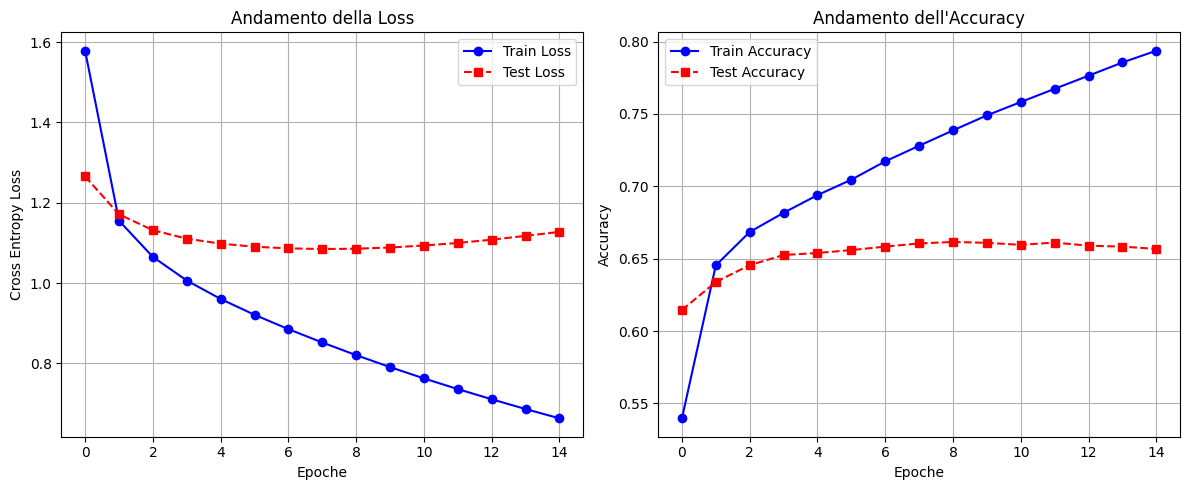

In [105]:
# Creazione della figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot della Loss
axes[0].plot(train_loss_hist, marker='o', linestyle='-', label="Train Loss", color="blue")
axes[0].plot(test_loss_hist, marker='s', linestyle='--', label="Test Loss", color="red")
axes[0].set_xlabel("Epoche")
axes[0].set_ylabel("Cross Entropy Loss")
axes[0].set_title("Andamento della Loss")
axes[0].legend()
axes[0].grid(True)

# Plot dell'Accuracy
axes[1].plot(train_acc_hist, marker='o', linestyle='-', label="Train Accuracy", color="blue")
axes[1].plot(test_acc_hist, marker='s', linestyle='--', label="Test Accuracy", color="red")
axes[1].set_xlabel("Epoche")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Andamento dell'Accuracy")
axes[1].legend()
axes[1].grid(True)

# Mostra i grafici
plt.tight_layout()
plt.show()

Si può vedere che dalle epoche 6-8 il miglioramento della *Test loss* rallenta, fino ad appiattirsi e ad iniziare ad invertire il trend dall'epoca 14 (Qui non viene mostrato, ma se aumentiamo il numero di epoche a 30 si vede chiaramente che la *Test loss* aumenta dall'espoca 14-15 in poi), evidenziando il fenomeno dell'*overfitting*. Anche il secondo grafico supporta l'ipotesi appena avanzata, infatti è evidente un chiaro "rallentamento" del miglioramento dell'accuracy a partire dalla epoca 6.   

Per questo modello, visto l'altissimo numero di parametri, non abbiamo proposto nessun tipo di ricerca sul loro spazio. 

# GDA: Gaussian Discriminant Classifier

In [107]:
def lda(X_train, y_train, X_test, y_test, title: str = 'LDA'):

    # create the model
    model = LinearDiscriminantAnalysis()

    # train the model
    model.fit(X_train, y_train)
    
    # make predictions and plot statistics and confusion matric
    valuate(model, X_test, y_test, title=title)

                     precision    recall  f1-score   support

              blues       0.20      0.11      0.14        18
          classical       0.64      0.79      0.71       129
            country       0.42      0.27      0.33        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.71      0.73      0.72      1264
       experimental       0.46      0.39      0.42       447
               folk       0.60      0.62      0.61       318
            hip-hop       0.66      0.63      0.64       438
       instrumental       0.46      0.43      0.44       284
      international       0.58      0.51      0.55       199
               jazz       0.44      0.44      0.44        88
old-time / historic       0.91      0.91      0.91        96
                pop       0.22      0.14      0.17       222
               rock       0.75      0.83      0.79      1393
           soul-rnb       0.38      0.17      0.24        35
             spoken    

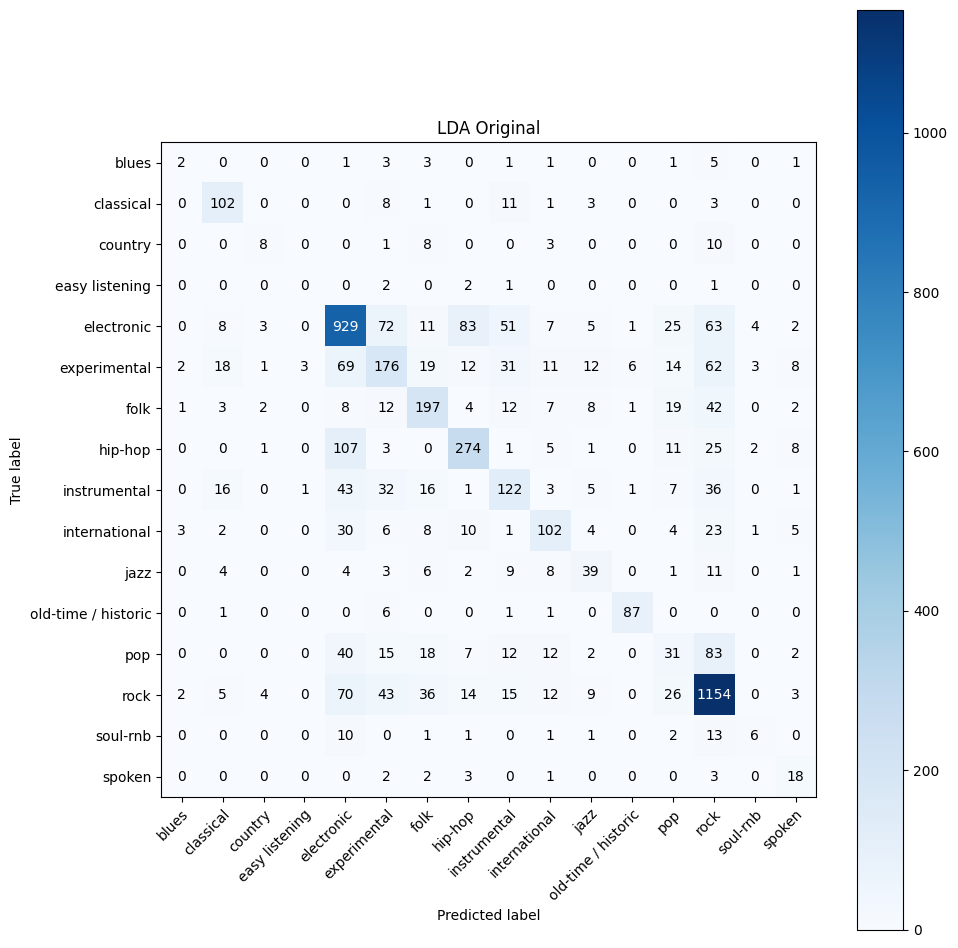

In [108]:
lda(X_trains[0], y_train, X_tests[0], y_test, title='LDA Original')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.59      0.78      0.67       129
            country       0.67      0.13      0.22        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.67      0.71      0.69      1264
       experimental       0.43      0.33      0.37       447
               folk       0.55      0.59      0.57       318
            hip-hop       0.59      0.59      0.59       438
       instrumental       0.39      0.37      0.38       284
      international       0.54      0.38      0.45       199
               jazz       0.41      0.39      0.40        88
old-time / historic       0.90      0.90      0.90        96
                pop       0.18      0.07      0.10       222
               rock       0.71      0.83      0.77      1393
           soul-rnb       0.50      0.03      0.05        35
             spoken    

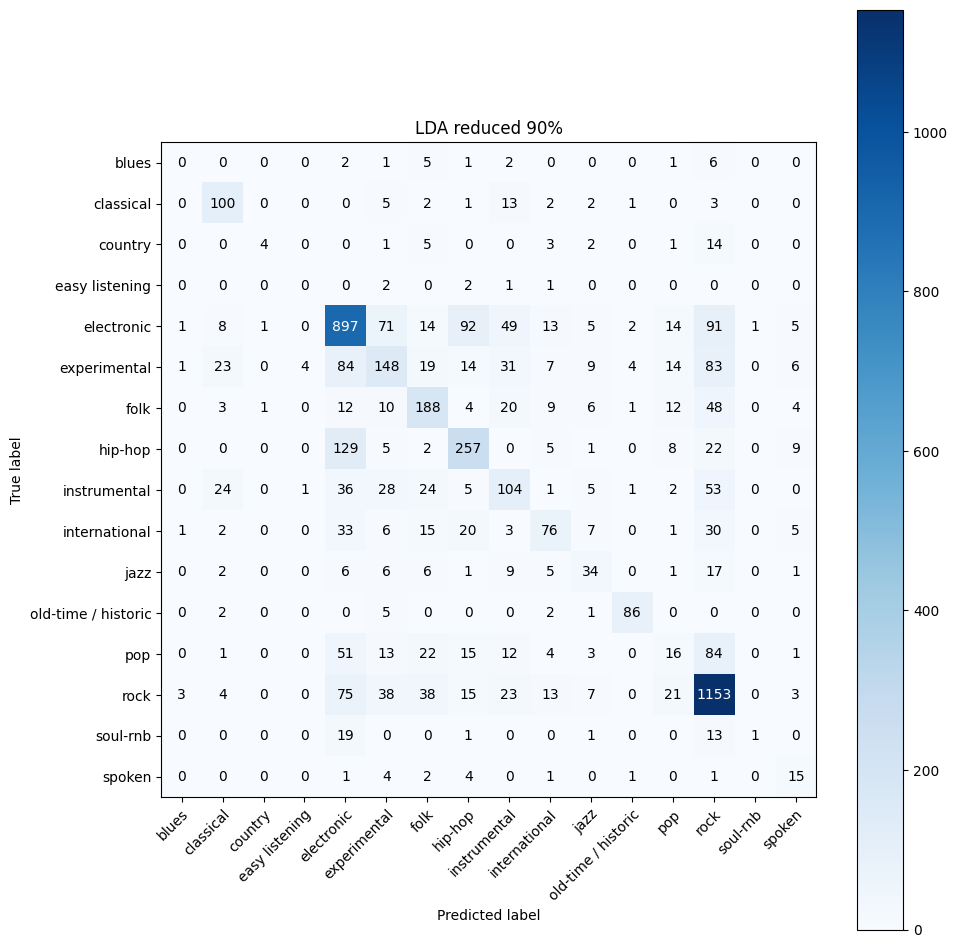

In [109]:
lda(X_trains[1], y_train, X_tests[1], y_test, title='LDA reduced 90%')

                     precision    recall  f1-score   support

              blues       0.00      0.00      0.00        18
          classical       0.52      0.71      0.60       129
            country       0.00      0.00      0.00        30
     easy listening       0.00      0.00      0.00         6
         electronic       0.63      0.71      0.67      1264
       experimental       0.42      0.29      0.34       447
               folk       0.53      0.62      0.57       318
            hip-hop       0.57      0.52      0.54       438
       instrumental       0.39      0.33      0.35       284
      international       0.49      0.30      0.37       199
               jazz       0.39      0.26      0.31        88
old-time / historic       0.86      0.88      0.87        96
                pop       0.23      0.04      0.07       222
               rock       0.69      0.84      0.76      1393
           soul-rnb       0.00      0.00      0.00        35
             spoken    

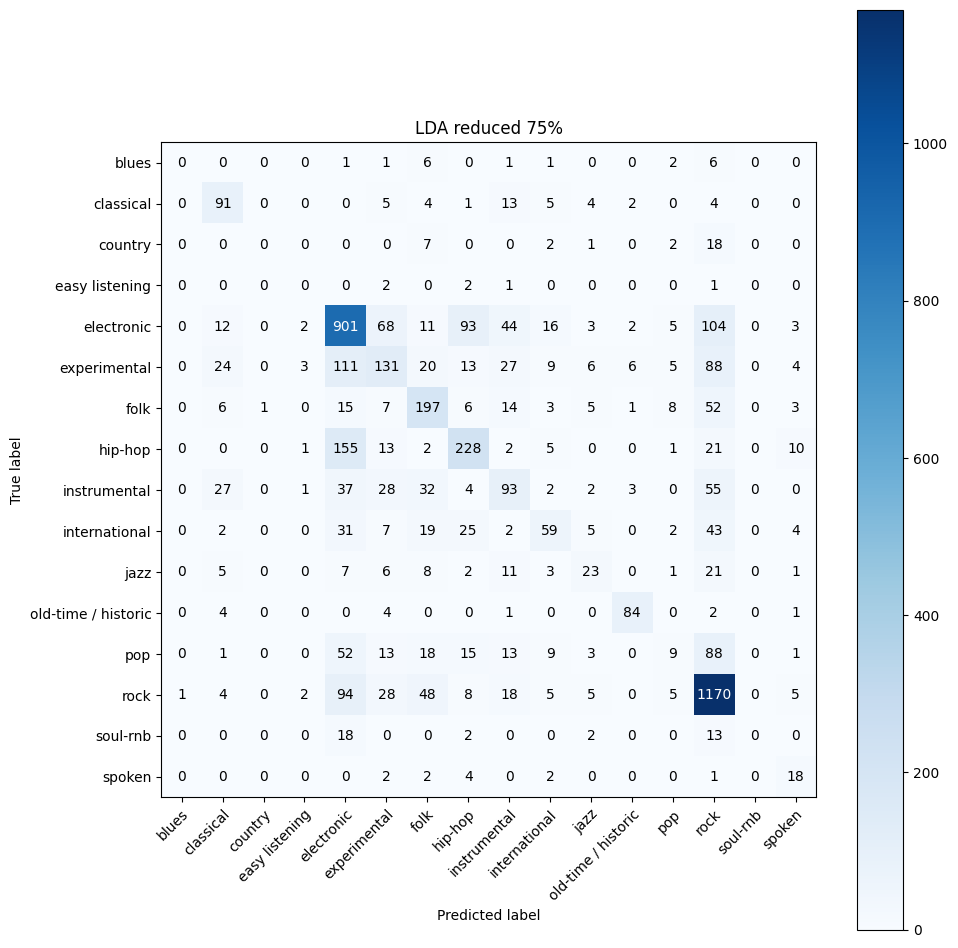

In [110]:
lda(X_trains[2], y_train, X_tests[2], y_test, title='LDA reduced 75%')

# kNN: k-Nearest-Neighbors

Qui, vista la presenza di un solo iper-parametro, ci limitiamo ad analizzare le performance dell'algoritmo al caso *k* $\in$ [1, 3, 5, 7, 9, 15, 25, 50] e plottiamo i risultati.

k=1: Accuracy=0.5620, F1_weighted=0.5558
k=3: Accuracy=0.5749, F1_weighted=0.5573
k=5: Accuracy=0.5801, F1_weighted=0.5569
k=7: Accuracy=0.5889, F1_weighted=0.5607
k=9: Accuracy=0.5885, F1_weighted=0.5557
k=15: Accuracy=0.5805, F1_weighted=0.5417
k=25: Accuracy=0.5797, F1_weighted=0.5366
k=50: Accuracy=0.5580, F1_weighted=0.5049


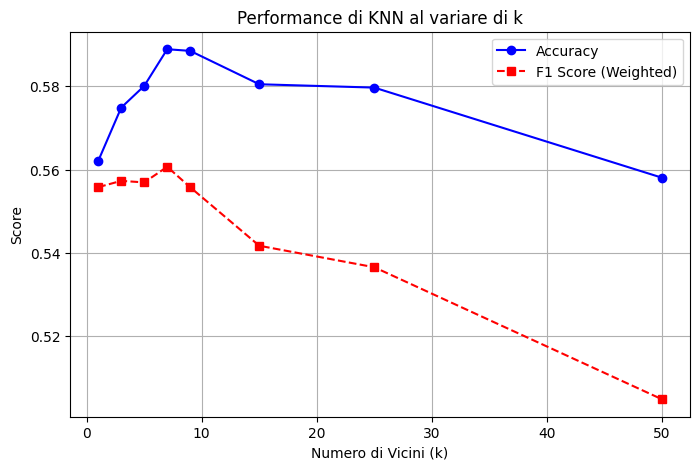

'ks = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]\ntrain_errs = []\ntest_errs = []\nfor k in ks:\n    knn = KNN(n_neighbors=k)\n    knn.fit(X_train, y_train)\n    train_errs.append(knn.score(X_train, y_train))\n    test_errs.append(knn.score(X_test, y_test))\n\nplt.style.use(\'ggplot\')\nplt.rcParams[\'font.family\'] = \'sans-serif\'\nplt.rcParams[\'font.serif\'] = \'Ubuntu\'\nplt.rcParams[\'font.monospace\'] = \'Ubuntu Mono\'\nplt.rcParams[\'font.size\'] = 10\nplt.rcParams[\'axes.labelsize\'] = 10\nplt.rcParams[\'axes.labelweight\'] = \'bold\'\nplt.rcParams[\'axes.titlesize\'] = 10\nplt.rcParams[\'xtick.labelsize\'] = 8\nplt.rcParams[\'ytick.labelsize\'] = 8\nplt.rcParams[\'legend.fontsize\'] = 10\nplt.rcParams[\'figure.titlesize\'] = 12\nplt.rcParams[\'image.cmap\'] = \'jet\'\nplt.rcParams[\'image.interpolation\'] = \'none\'\nplt.rcParams[\'figure.figsize\'] = (16, 8)\nplt.rcParams[\'lines.linewidth\'] = 2\nplt.rcParams[\'lines.markersize\'] = 8\n\ncolors = [\'#008fd5\'

In [ ]:
import matplotlib.colors as mcolors

k_values = [1, 3, 5, 7, 9, 15, 25, 50]
X_train, X_test = X_trains[1], X_tests[1]

# Liste per salvare le metriche
accuracy_values = []
f1_values = []

# Loop su k
for k in k_values:
    model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    accuracy_values.append(acc)
    f1_values.append(f1)

    print(f"k={k}: Accuracy={acc:.4f}, F1_weighted={f1:.4f}")

# Creazione del grafico
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracy_values, marker='o', linestyle='-', label="Accuracy", color="blue")
plt.plot(k_values, f1_values, marker='s', linestyle='--', label="F1 Score (Weighted)", color="red")

plt.xlabel("Numero di Vicini (k)")
plt.ylabel("Score")
plt.title("Performance di KNN al variare di k")
plt.legend()
plt.grid(True)
plt.show()

# Extreme Gradient Boosting

In [114]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

def XGB(X_train, y_train, X_test, y_test, title: str = 'Extreme Gradient Boosting'):

    label_encoder = LabelEncoder()
    y_test_encoded = label_encoder.fit_transform(y_test)
    y_train_encoded = label_encoder.fit_transform(y_train)

    model = XGBClassifier()

    model.fit(X_train, y_train_encoded)

    valuate(model, X_test, y_test_encoded, title=title)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.80      0.80      0.80       129
           2       1.00      0.17      0.29        30
           3       0.00      0.00      0.00         6
           4       0.64      0.82      0.72      1264
           5       0.48      0.42      0.44       447
           6       0.65      0.60      0.62       318
           7       0.73      0.61      0.67       438
           8       0.55      0.45      0.49       284
           9       0.72      0.51      0.60       199
          10       0.74      0.36      0.49        88
          11       0.91      0.98      0.94        96
          12       0.28      0.09      0.14       222
          13       0.73      0.85      0.79      1393
          14       0.00      0.00      0.00        35
          15       0.75      0.21      0.32        29

    accuracy                           0.67      4996
   macro avg       0.56   

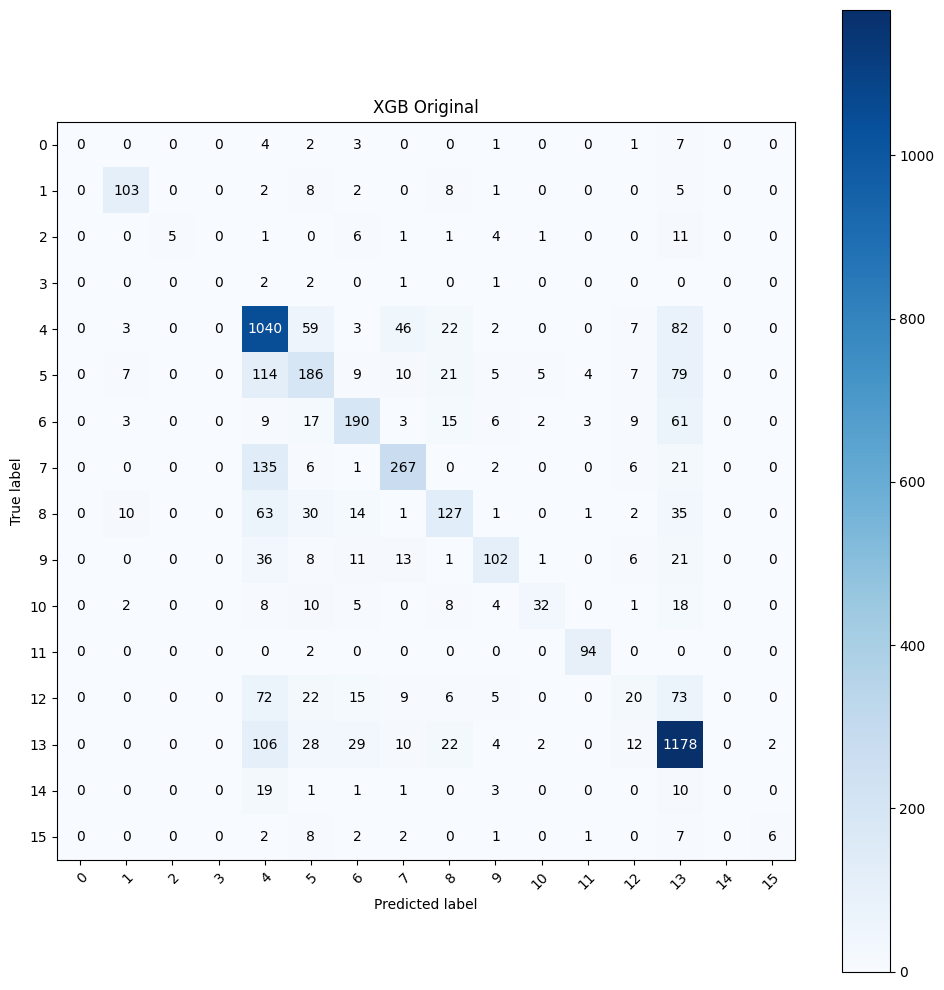

In [115]:
XGB(X_trains[0], y_train, X_tests[0], y_test, title="XGB Original")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.69      0.67      0.68       129
           2       1.00      0.03      0.06        30
           3       0.00      0.00      0.00         6
           4       0.62      0.80      0.70      1264
           5       0.46      0.38      0.42       447
           6       0.62      0.57      0.59       318
           7       0.65      0.53      0.58       438
           8       0.54      0.35      0.42       284
           9       0.74      0.37      0.49       199
          10       0.73      0.25      0.37        88
          11       0.93      0.91      0.92        96
          12       0.29      0.07      0.12       222
          13       0.67      0.85      0.75      1393
          14       1.00      0.03      0.06        35
          15       0.71      0.17      0.28        29

    accuracy                           0.63      4996
   macro avg       0.60   

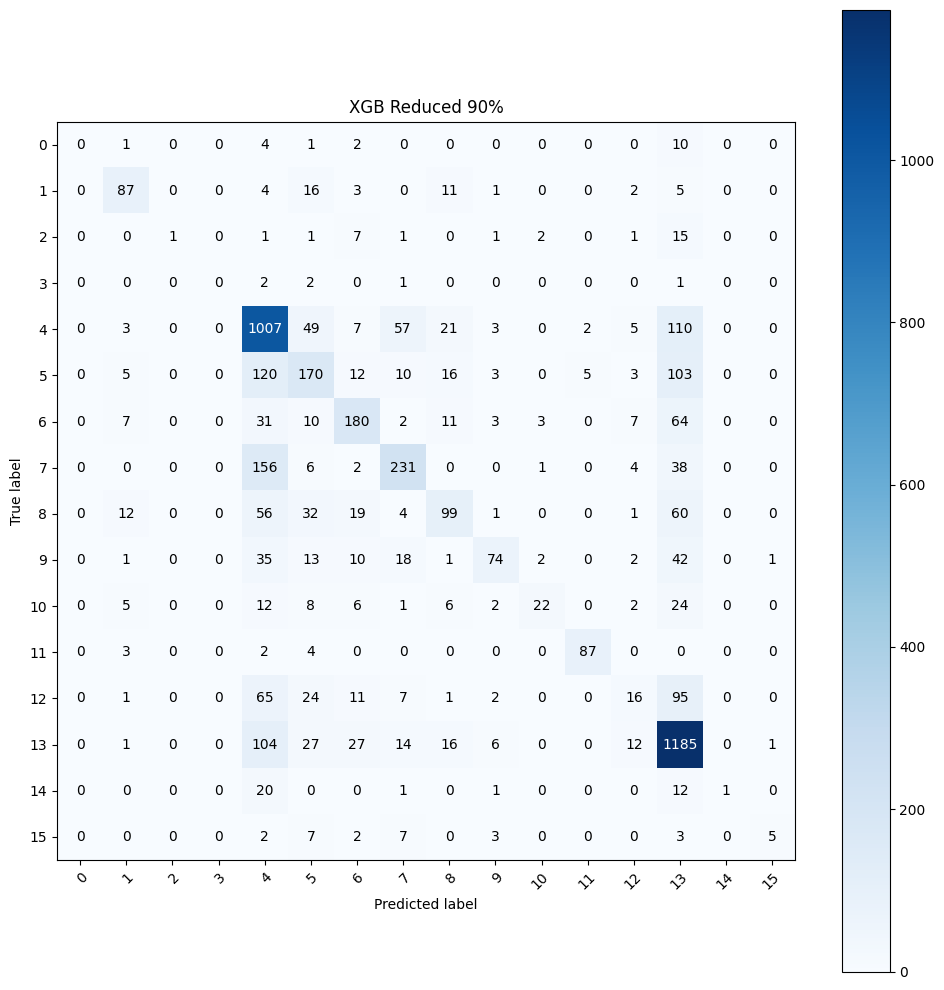

In [116]:
XGB(X_trains[1], y_train, X_tests[1], y_test, title="XGB Reduced 90%")

              precision    recall  f1-score   support

           0       1.00      0.11      0.20        18
           1       0.75      0.71      0.73       129
           2       1.00      0.03      0.06        30
           3       0.00      0.00      0.00         6
           4       0.61      0.78      0.69      1264
           5       0.46      0.37      0.41       447
           6       0.60      0.58      0.59       318
           7       0.62      0.49      0.55       438
           8       0.45      0.30      0.36       284
           9       0.70      0.44      0.54       199
          10       0.62      0.28      0.39        88
          11       0.95      0.93      0.94        96
          12       0.24      0.07      0.11       222
          13       0.69      0.84      0.76      1393
          14       1.00      0.06      0.11        35
          15       0.73      0.28      0.40        29

    accuracy                           0.63      4996
   macro avg       0.65   

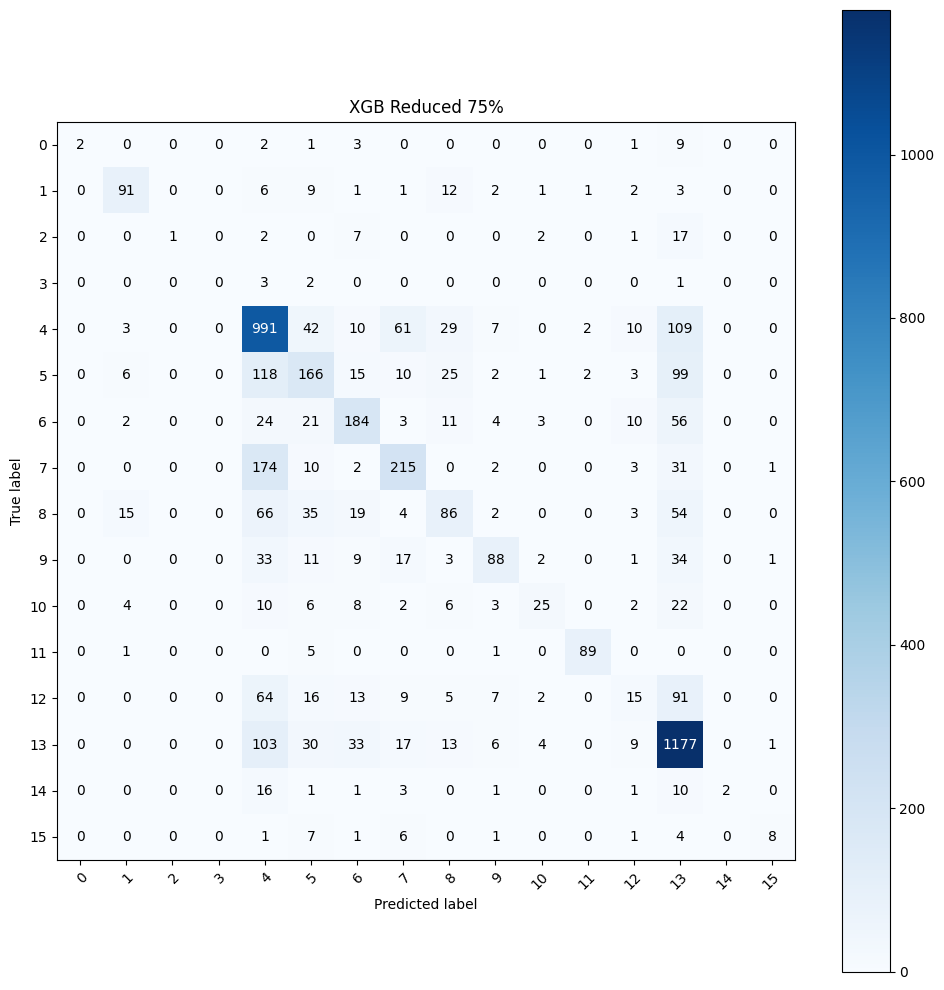

In [117]:
XGB(X_trains[2], y_train, X_tests[2], y_test, title="XGB Reduced 75%")

## -----

# Conclusioni

In questo studio, abbiamo analizzato e confrontato diversi algoritmi di classificazione per il nostro dataset: 
- **Support Vector Machine (SVM)**
- **Decision Tree**
- **Bagging**
- **Boosting**
- **Rete Neurale**
- **Softmax Regression**
- **Gaussian Discriminant Analysis (GDA)**
- **k-Nearest Neighbors (kNN)**
- **Locally-weighted Softmax Regression**

L'obiettivo era valutare le loro prestazioni utilizzando diverse metriche, tra cui accuratezza, F1-score e matrice di confusione.

## Metodologia

Abbiamo iniziato con la preparazione del dataset, includendo la normalizzazione e la selezione delle feature più rilevanti tramite PCA. Successivamente, abbiamo addestrato e testato ogni modello utilizzando una suddivisione train-test e, per tutti i modelli eccetto Multilayer Perceptron, abbiamo esplorato diversi valori degli iperparametri per ottimizzare le performance.

## Limitazioni e sviluppi futuri

Questo studio presenta alcune limitazioni che potrebbero influenzare i risultati ottenuti:

- **Rappresentazione dei dati**: Non abbiamo utilizzato tecniche avanzate come autoencoder o altre forme di apprendimento non supervisionato per l'estrazione automatica delle feature, ma ci siamo limitati alle feature estratte con dei software di *Audio Signal Processing*.

- **Dataset sbilanciato**: L'analisi è stata condotta su un dataset fortemente sbilanciato, il che ha influenzato le prestazioni dei modelli e la capacità di generalizzazione, favorendo le classi più rappresentate.

- **Modelli non deep**: Tutti i modelli utilizzati appartengono alla famiglia del machine learning tradizionale e non abbiamo esplorato approcci deep learning, che potrebbero offrire prestazioni superiori in determinati contesti.

Ulteriori miglioramenti potrebbero essere ottenuti con tecniche di selezione delle feature più avanzate o con l'uso di modelli più sofisticati, come gli autoencoder (con RNN). Un'analisi più approfondita sull'importanza delle feature potrebbe anche fornire indicazioni utili per migliorare la classificazione.

In futuro, sarebbe interessante sperimentare con set di dati più ampi e diversificati, oltre a integrare tecniche di ottimizzazione iperparametrica per migliorare ulteriormente le performance dei modelli testati.

# Locally-weighted softmax regression

Questo è l'unico algoritmo non *model-based* che abbiamo proposto. Consiste in una softmax regression in cui, però, quando si vuole fare la previsione per un punto, si da maggiore rilevanza ai punti nelle sue vicinanze.

In [31]:
acc = []
tau = 0.5  # Bandwidth parameter

for x in range(len(X_test)):
    # Query point
    x_query = X_test[x].reshape(1, -1)  # Assicura che sia della giusta dimensione
    y_query = y_test[x]  # Non usare reshape, è un singolo valore

    # Compute weights using Gaussian kernel
    distances = np.linalg.norm(X_train - x_query, axis=1) ** 2
    weights = np.exp(-distances / (2 * tau**2))  # Gaussian weighting

    # Train weighted softmax regression
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
    model.fit(X_train, y_train, sample_weight=weights)

    # Predict on test set
    y_pred = model.predict(x_query)[0]  # Prendi il valore scalare

    # Accuracy
    accuracy = (y_pred == y_query).astype(float)  # Converte True/False in 1.0/0.0
    acc.append(accuracy)

    print(f"Accuracy for sample {x}: {accuracy:.2f}")

# Print overall accuracy
print(f"Overall accuracy: {np.mean(acc):.2f}")

KeyError: 0

In [43]:
acc = []
tau = 0.5  # Bandwidth parameter

# Otteniamo i track_id dal test set
track_ids = y_test.index  # Supponiamo che y_test sia una Pandas Series con track_id come indice

# Iteriamo su tutti i track_id nel test set
for i, track_id in enumerate(track_ids):  
    # Recuperiamo il punto di test e l'etichetta associata
    x_query = X_test[i].reshape(1, -1)  # X_test è un array NumPy, quindi accediamo con indici interi
    y_query = y_test.loc[track_id]  # Accediamo a y_test usando il track_id

    # Calcoliamo i pesi usando il kernel gaussiano
    distances = np.linalg.norm(X_train - x_query, axis=1) ** 2
    weights = np.exp(-distances / (2 * tau**2))  # Gaussian weighting

    # Alleniamo la regressione logistica con pesi
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500)
    model.fit(X_train, y_train, sample_weight=weights)

    # Prediciamo il valore per il test point
    y_pred = model.predict(x_query)[0]  

    # Calcoliamo l'accuratezza
    accuracy = float(y_pred == y_query)  
    acc.append(accuracy)

    print(f"Accuracy for track_id {track_id}: {accuracy:.2f} | Prediction: {y_pred} | True label: {y_query}")

# Stampiamo l'accuratezza complessiva
print(f"Overall accuracy: {np.mean(acc):.2f}")

Accuracy for track_id 110711: 0.00 | Prediction: Blues | True label: genre    Experimental
Name: 110711, dtype: object
Accuracy for track_id 97958: 0.00 | Prediction: Blues | True label: genre    Electronic
Name: 97958, dtype: object
Accuracy for track_id 72789: 0.00 | Prediction: Blues | True label: genre    Hip-Hop
Name: 72789, dtype: object
Accuracy for track_id 16337: 0.00 | Prediction: Blues | True label: genre    Pop
Name: 16337, dtype: object
Accuracy for track_id 55828: 0.00 | Prediction: Blues | True label: genre    International
Name: 55828, dtype: object
Accuracy for track_id 93930: 0.00 | Prediction: Blues | True label: genre    Electronic
Name: 93930, dtype: object
Accuracy for track_id 69789: 0.00 | Prediction: Blues | True label: genre    Experimental
Name: 69789, dtype: object
Accuracy for track_id 64023: 0.00 | Prediction: Blues | True label: genre    Rock
Name: 64023, dtype: object
Accuracy for track_id 46007: 0.00 | Prediction: Blues | True label: genre    Experiment

KeyboardInterrupt: 

In [39]:
type(X_test)

numpy.ndarray